# Compare vaccination strategies per ERVA and age groups. $e$=0.7

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
from experiments import get_experiments_results
from env_var import EPIDEMIC, MAPPINGS, EXPERIMENTS
from matplotlib.lines import Line2D

mpl.rcParams['text.usetex'] = True
mpl.rcParams['figure.dpi']= 175
plt.style.use('ggplot')

In [2]:
# Simulation parameters
num_age_groups = EXPERIMENTS['num_age_groups']
num_ervas = EXPERIMENTS['num_ervas']
T = EXPERIMENTS['simulate_T']
init_vacc = EXPERIMENTS['init_vacc']
taus = EXPERIMENTS['taus']
u = EXPERIMENTS['vaccines_per_day']
r_experiments = EXPERIMENTS['r_effs']
t0 = EXPERIMENTS['t0']
e = EPIDEMIC['e']
strategies = EXPERIMENTS['strategies']

# Plot parameters
plot_interval = 15
ervas_labels = EPIDEMIC['ervas_order']
age_labels = MAPPINGS['age_groups'][num_age_groups]['names']
color_palette = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
len_bar = 5
sep_bet_group = 4*len_bar
legend_width = 4

begin = datetime.datetime.strptime(t0, '%Y-%m-%d')
ts = [begin + datetime.timedelta(days=day) for day in range(T)]
print('Simulation ends: %s' % (ts[-1]))
t2 = int(T-1)
t1 = t2-30

Simulation ends: 2021-08-10 00:00:00


In [3]:
exp_results = get_experiments_results(num_age_groups=num_age_groups,
                                      num_ervas=num_ervas,
                                      init_vacc=init_vacc,
                                      strategies=strategies,
                                      u=u,
                                      T=T,
                                      r_experiments=r_experiments,
                                      t0=t0,
                                      e=e,
                                      taus=taus)

Beginning experiments.
Parameters:
Number of age ervas: 5.
Number of age groups: 9.
Number of vaccines per day: 30000.
t0: 2021-04-18.
T: 115.
Vaccine efficacy (e): 0.7.
Rs to try: [0.75, 1.0, 1.25, 1.5].
Taus to try: [0, 0.5, 1.0].
Initialize with vaccinated people: True.
Strategies:
[([1, 0, 0], 'Pop only'), ([0, 0, 0], 'No vaccination'), ([0.3333333333333333, 0.3333333333333333, 0.3333333333333333], 'Pop, Inf and Hosp'), ([0.5, 0, 0.5], 'Pop and Hosp'), ([0.5, 0.5, 0], 'Pop and Inf'), ([0, 0.5, 0.5], 'Hosp and Inf'), ([0, 0, 1], 'Hosp only'), ([0, 1, 0], 'Inf only'), (None, 'Optimized')].

Running 96 experiments with 4 CPUS.
Start (33969). Exp: 1. R: 0.75. tau: 0. Policy: Pop onlyStart (33970). Exp: 2. R: 0.75. tau: 0. Policy: No vaccinationStart (33971). Exp: 3. R: 0.75. tau: 0. Policy: Pop, Inf and HospStart (33972). Exp: 4. R: 0.75. tau: 0. Policy: Pop and Hosp



Finished (33969). Exp: 1. Elapsed: 0:00:03.882868
Start (33969). Exp: 5. R: 0.75. tau: 0. Policy: Pop and Inf
Finishe

Finished (33970). Exp: 82. Elapsed: 0:00:07.627444
Start (33969). Exp: 85. R: 1.25. tau: 1.0. Policy: Pop and InfStart (33970). Exp: 86. R: 1.25. tau: 1.0. Policy: Hosp and Inf

Finished (33971). Exp: 83. Elapsed: 0:00:07.675974
Start (33971). Exp: 87. R: 1.25. tau: 1.0. Policy: Hosp only
Finished (33972). Exp: 84. Elapsed: 0:00:07.708293
Start (33972). Exp: 88. R: 1.25. tau: 1.0. Policy: Inf only
Finished (33969). Exp: 85. Elapsed: 0:00:06.530479
Start (33969). Exp: 25. R: 1.5. tau: 0. Policy: Pop only
Finished (33970). Exp: 86. Elapsed: 0:00:06.594947
Start (33970). Exp: 26. R: 1.5. tau: 0. Policy: No vaccination
Finished (33971). Exp: 87. Elapsed: 0:00:06.548728
Start (33971). Exp: 27. R: 1.5. tau: 0. Policy: Pop, Inf and Hosp
Finished (33972). Exp: 88. Elapsed: 0:00:06.511350
Start (33972). Exp: 28. R: 1.5. tau: 0. Policy: Pop and Hosp
Finished (33969). Exp: 25. Elapsed: 0:00:07.200660
Start (33969). Exp: 29. R: 1.5. tau: 0. Policy: Pop and Inf
Finished (33970). Exp: 26. Elapsed: 0

In [4]:
def plot_bars_ages_ervas(ax, r, tau, metric, exp_results, labels, plot, t2=t2, t1=t1,
                         baseline='Pop only', skip_no_vacc=True):
    # Get the results only for the specified r and tau
    results = exp_results[r][tau]
    
    # Count how many strategies we have
    total_strategies = len(results.keys())
    skip_num = 1
    if skip_no_vacc:
        skip_num += 1
    # Space for a set of bars (for one ERVA or Age group)
    space_label = len_bar*(total_strategies-skip_num) + sep_bet_group
    
    # Find the strategy acting as baseline and get the results for it
    baseline_cumm = None
    for label, label_level in results.items():
        if label == baseline:
            baseline_results = label_level['results'][metric]
            baseline_cumm = baseline_results.cumsum(axis=2)

            if plot == 'ERVA':
                baseline_cumm = baseline_cumm.sum(axis=0)
            elif plot == 'Age group':
                baseline_cumm = baseline_cumm.sum(axis=1)
            else:
                raise ValueError('Not valid value to plot')
    
    assert baseline_cumm is not None
    
    # Reserve space for the complete plot (all ERVAs or Age groups)
    total_plot_space = space_label*len(labels) + sep_bet_group
    ax.set_xlim(0, total_plot_space)
    
    # Iterate over the strategies, get result wrt baseline and plot
    num_strategy = 0
    legend_elements = []
    for label, label_level in results.items():
        if label == baseline:
            continue
        
        if label == 'No vaccination' and skip_no_vacc:
            continue

        # Get the results for this strategy
        policy_results = label_level['results'][metric]
        policy_cumm = policy_results.cumsum(axis=2)

        if plot == 'ERVA':
            policy_cumm = policy_cumm.sum(axis=0)
        elif plot == 'Age group':
            policy_cumm = policy_cumm.sum(axis=1)
        else:
            raise ValueError('Not valid value to plot')

                
        assert policy_cumm.shape == baseline_cumm.shape
        assert policy_cumm.shape[0] == len(labels)

        # Obtain the the results for all the ERVAs and age groups
        relative_to_baseline = policy_cumm/baseline_cumm
        relative_to_baseline = np.nan_to_num(relative_to_baseline, nan=1)
        relative_to_baseline = relative_to_baseline - 1
        relative_to_baseline = relative_to_baseline*100

        # Get the results between t1 and t2
        min_reduction = relative_to_baseline[:, t1]
        max_reduction = relative_to_baseline[:, t2]


        color_i = num_strategy % len(color_palette)
        color = color_palette[color_i]
        # Iterating the ERVAs or Age groups.
        for label_i in range(len(labels)):
            # Getting the the dimensions of the bar
            x1_square = label_i*space_label + sep_bet_group + num_strategy*len_bar
            y1_square = min_reduction[label_i]
            y2_square = max_reduction[label_i] - min_reduction[label_i]

            # Plot the result of this policy to the current ERVA or Age group
            ax.broken_barh([(x1_square, len_bar), ], (y1_square, y2_square),
                           color=color)

        # Add one element to the legends for this strategy
        legend_elements.append(Line2D([0], [0], color=color, lw=legend_width, label=label))
        num_strategy += 1
    
    # Getting the positions for the ticks and labeling the labels for them
    space_bars = space_label - sep_bet_group
    middle_of_space = space_bars/2
    pos_tick =  sep_bet_group + middle_of_space
    ticks = []
    for label_i in range(len(labels)):
        abs_pos_tick = label_i*space_label + pos_tick
        ticks.append(abs_pos_tick)
        
    assert len(ticks) == len(labels)
    assert len(legend_elements) == total_strategies-skip_num
    
    # Add ticks and labels
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    ax.set_xlabel(plot)
    ax.set_ylabel('Reduction in percentage')
    ax.set_title('Reduction in %s at %ss per policy . R=%s' % (metric, plot, r))
    ax.legend(handles=legend_elements, loc='upper left', framealpha=0.5)
    

    return ax

# Deaths

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


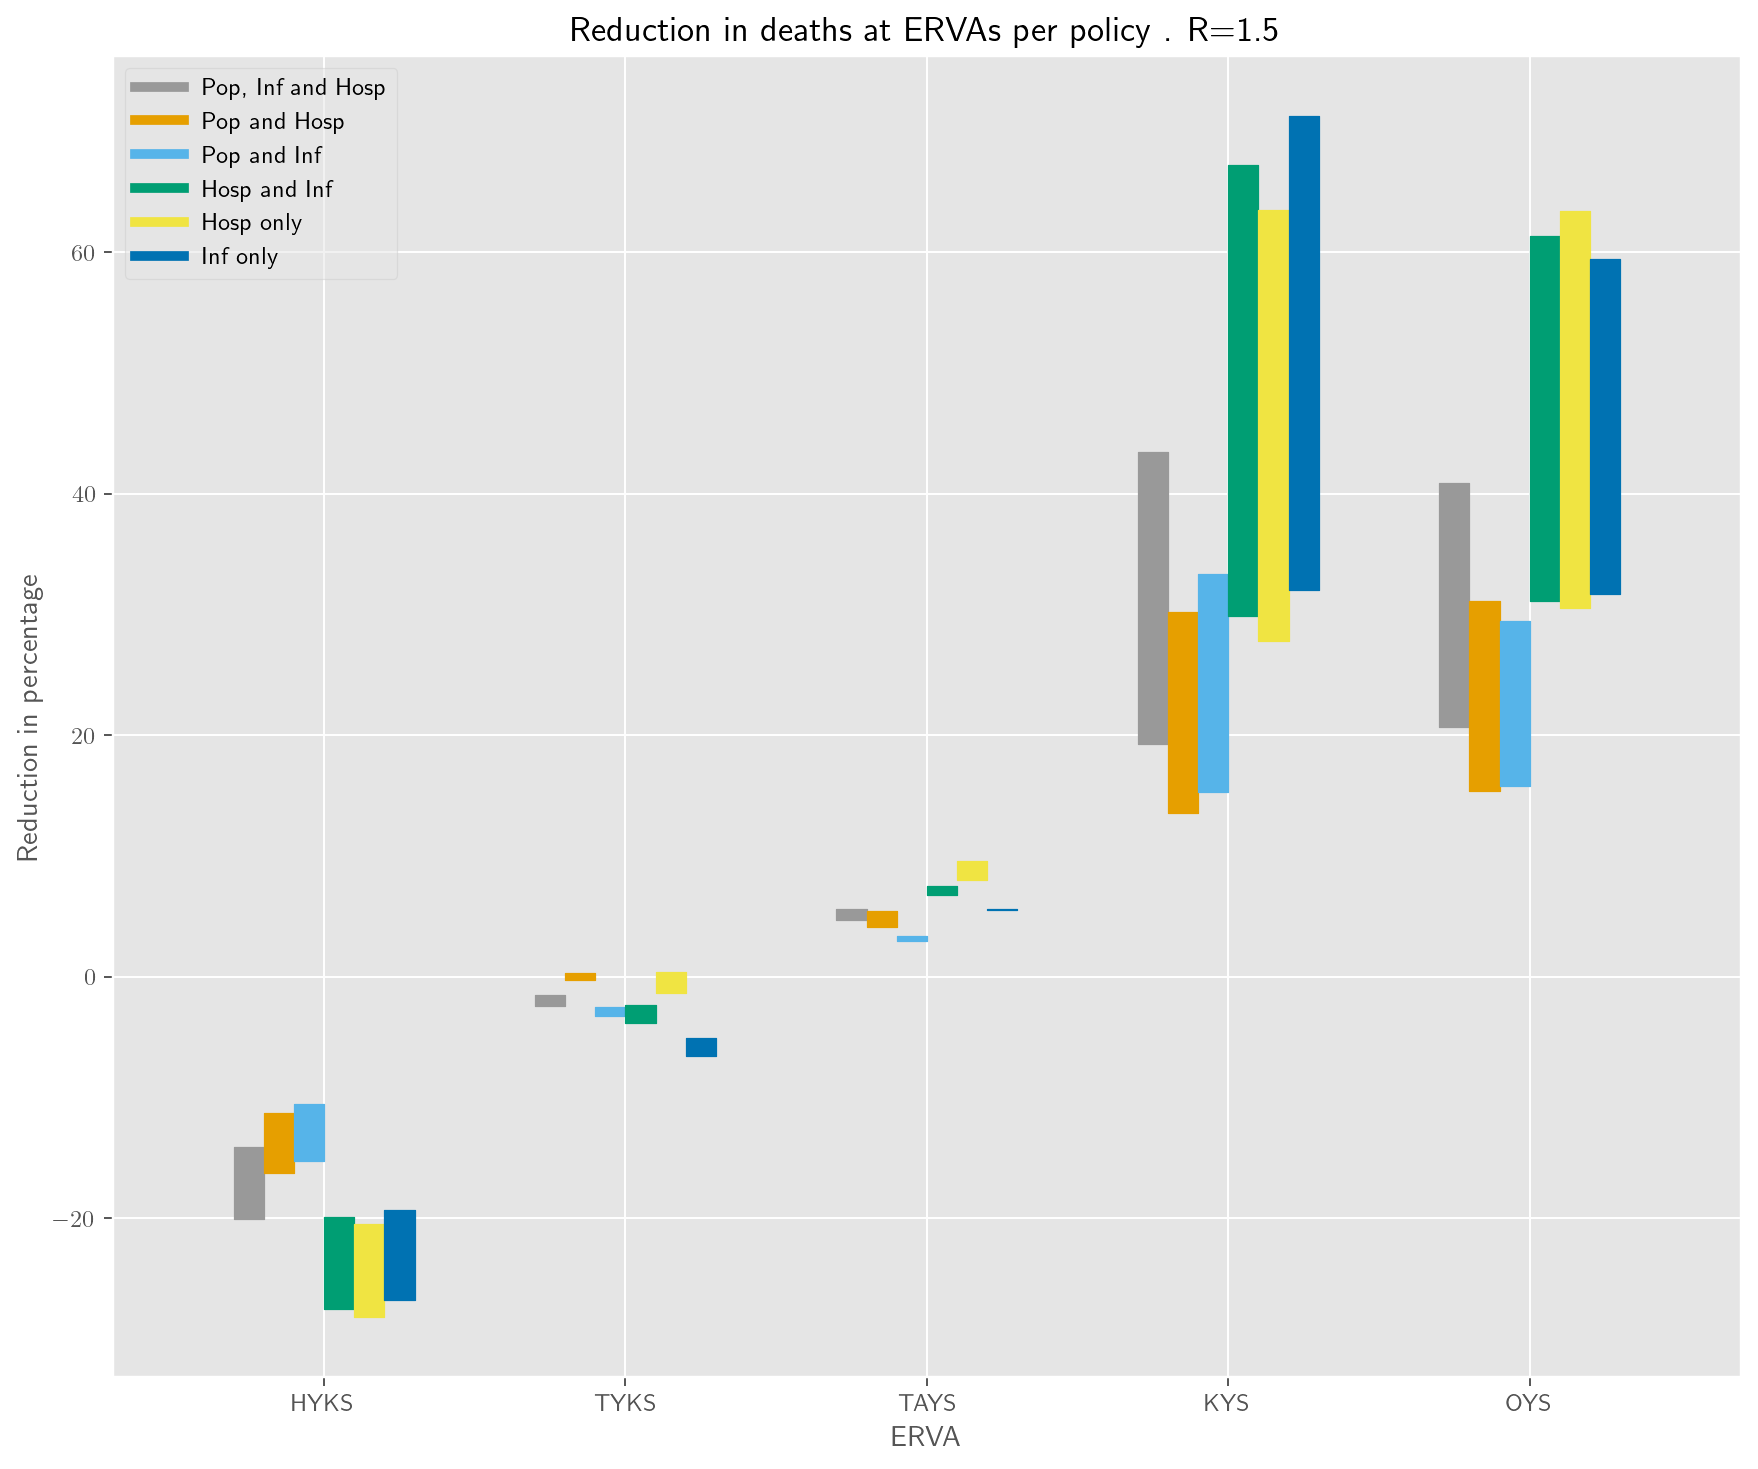

In [5]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r=1.5, tau=0.5, metric='deaths', exp_results=exp_results, labels=ervas_labels,
                          plot='ERVA', t2=t2, t1=t1, baseline='Pop only', skip_no_vacc=True)

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


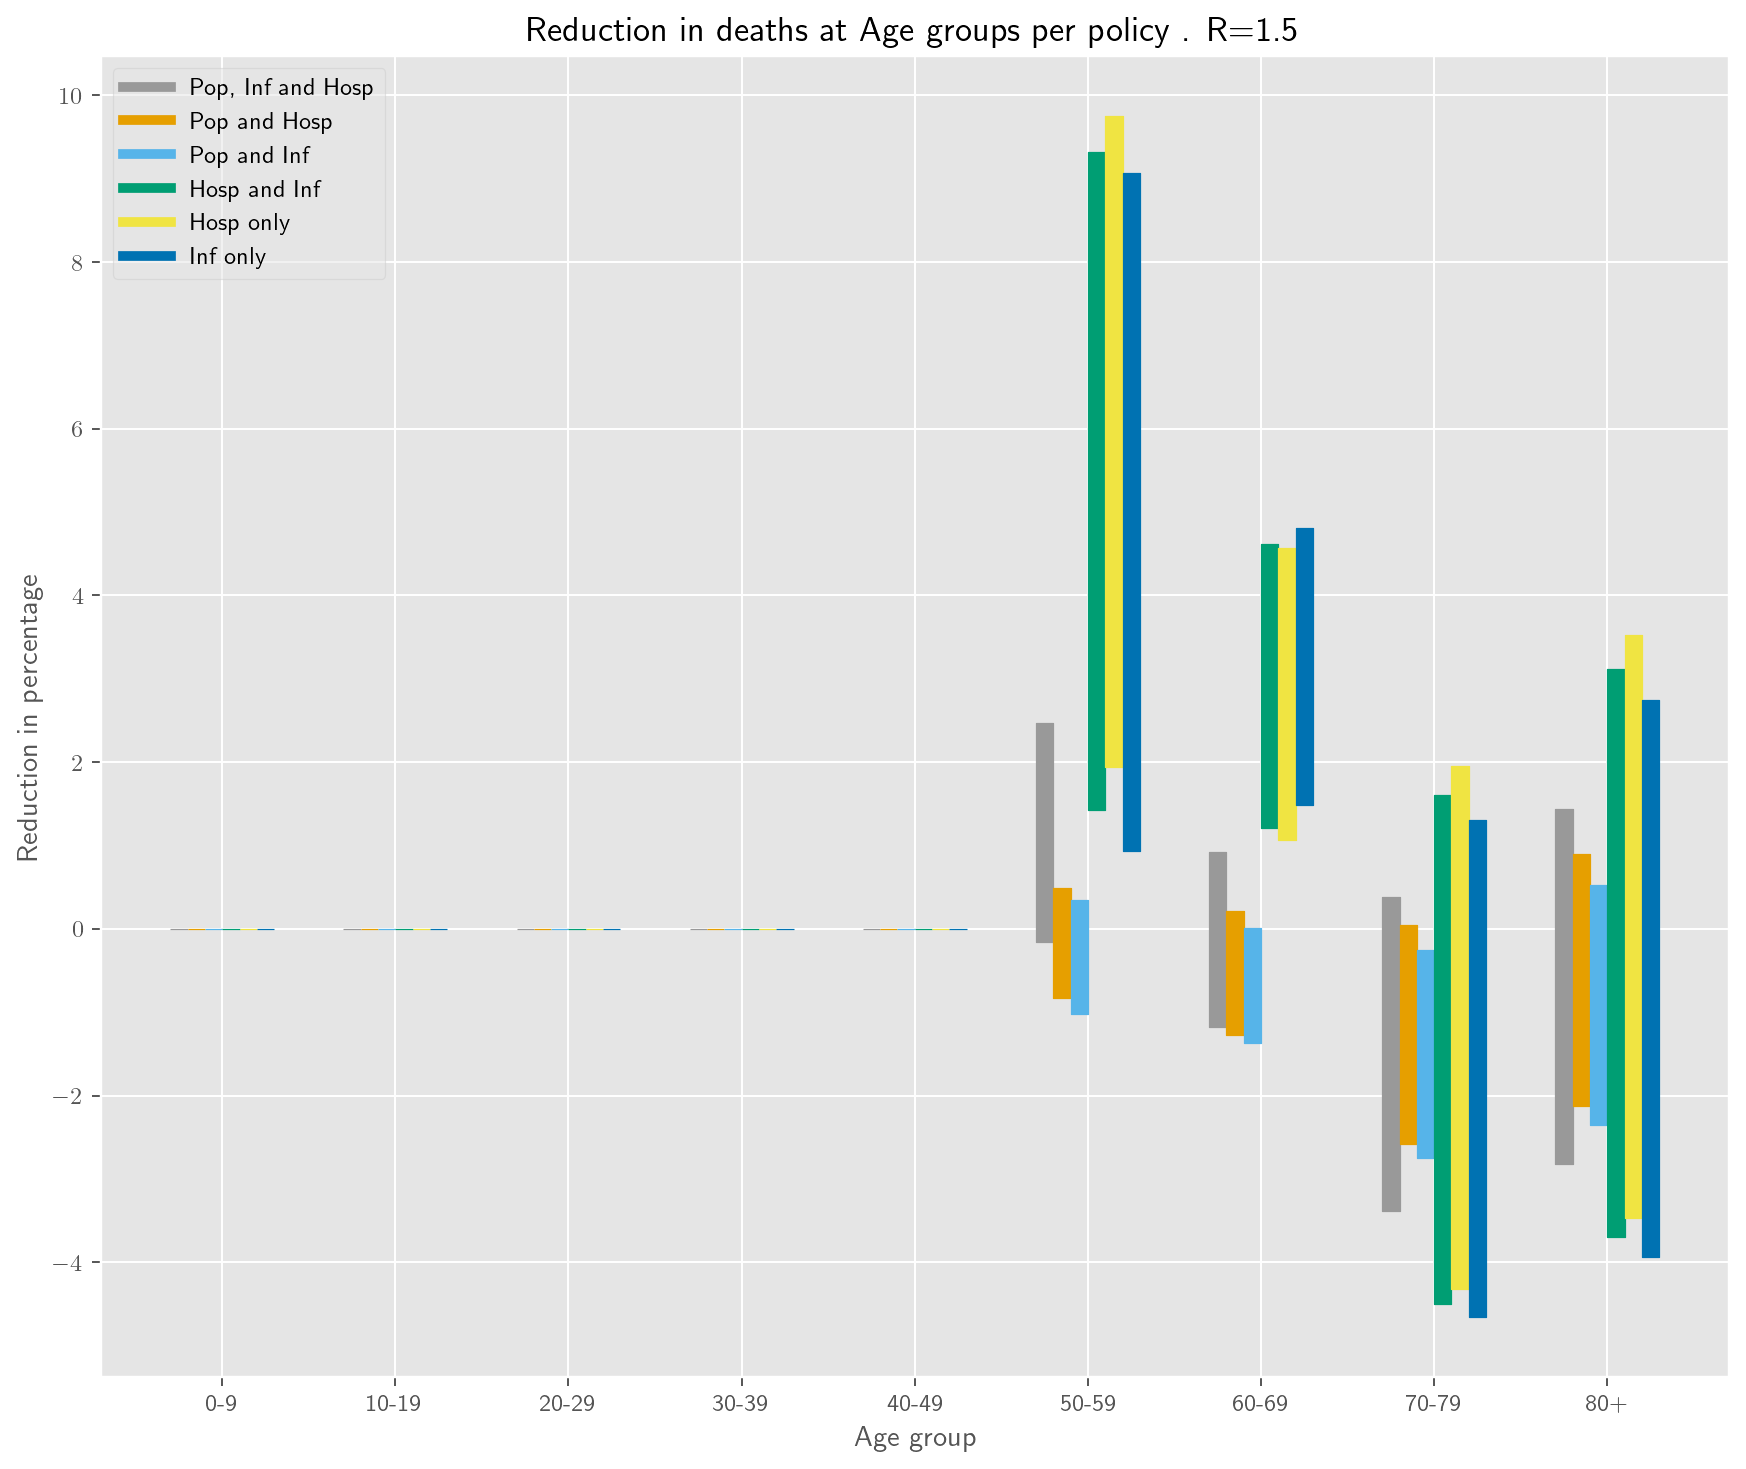

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r=1.5, tau=0.5, metric='deaths', exp_results=exp_results, labels=age_labels,
                          plot='Age group', t2=t2, t1=t1, baseline='Pop only', skip_no_vacc=True)

# Hospitalizations

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


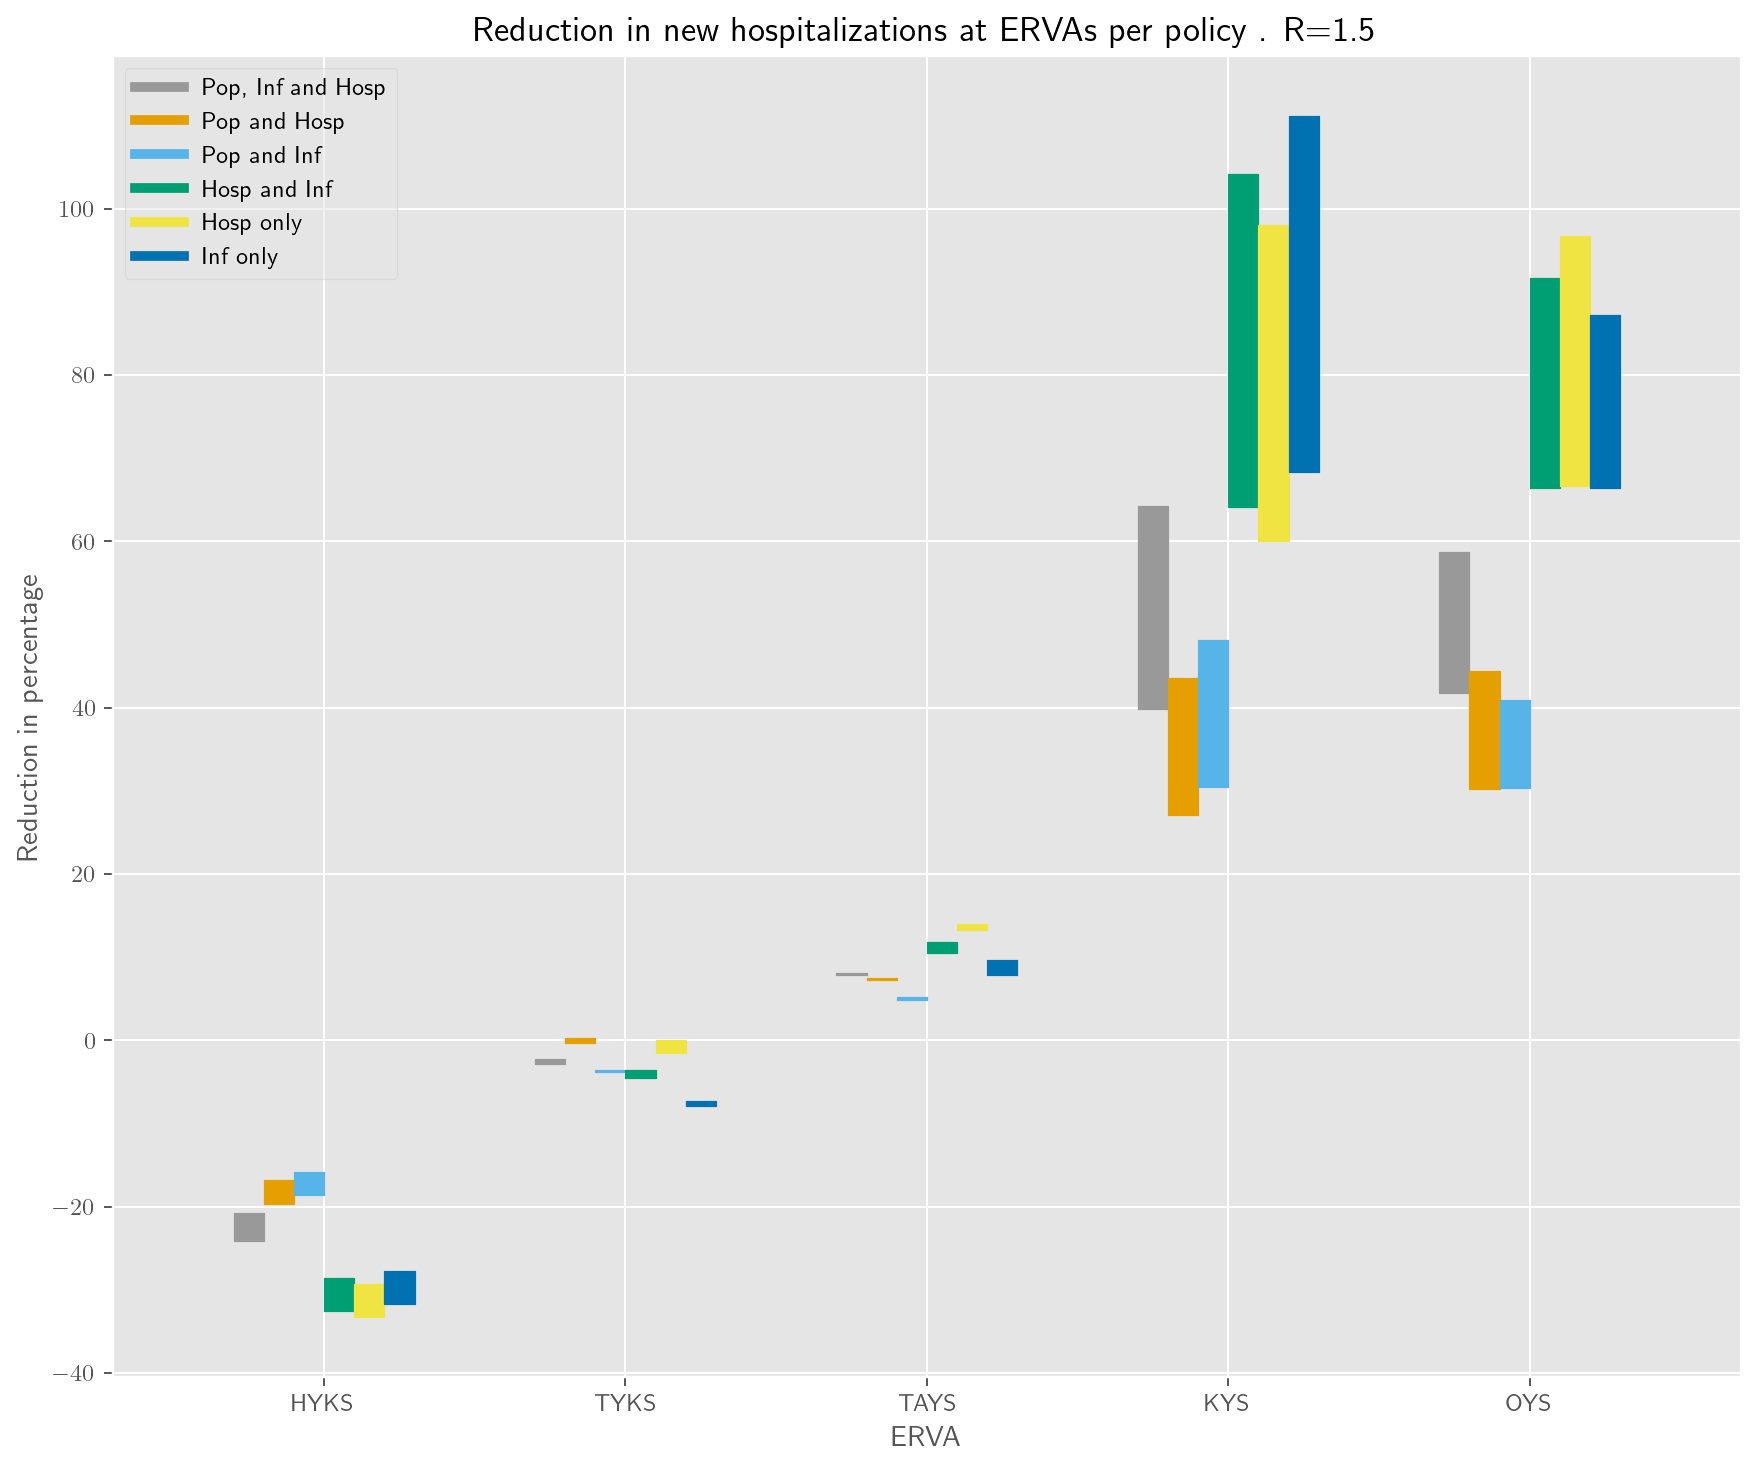

In [7]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r=1.5, tau=0.5, metric='new hospitalizations', exp_results=exp_results, labels=ervas_labels,
                          plot='ERVA', t2=t2, t1=t1, baseline='Pop only', skip_no_vacc=True)

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide


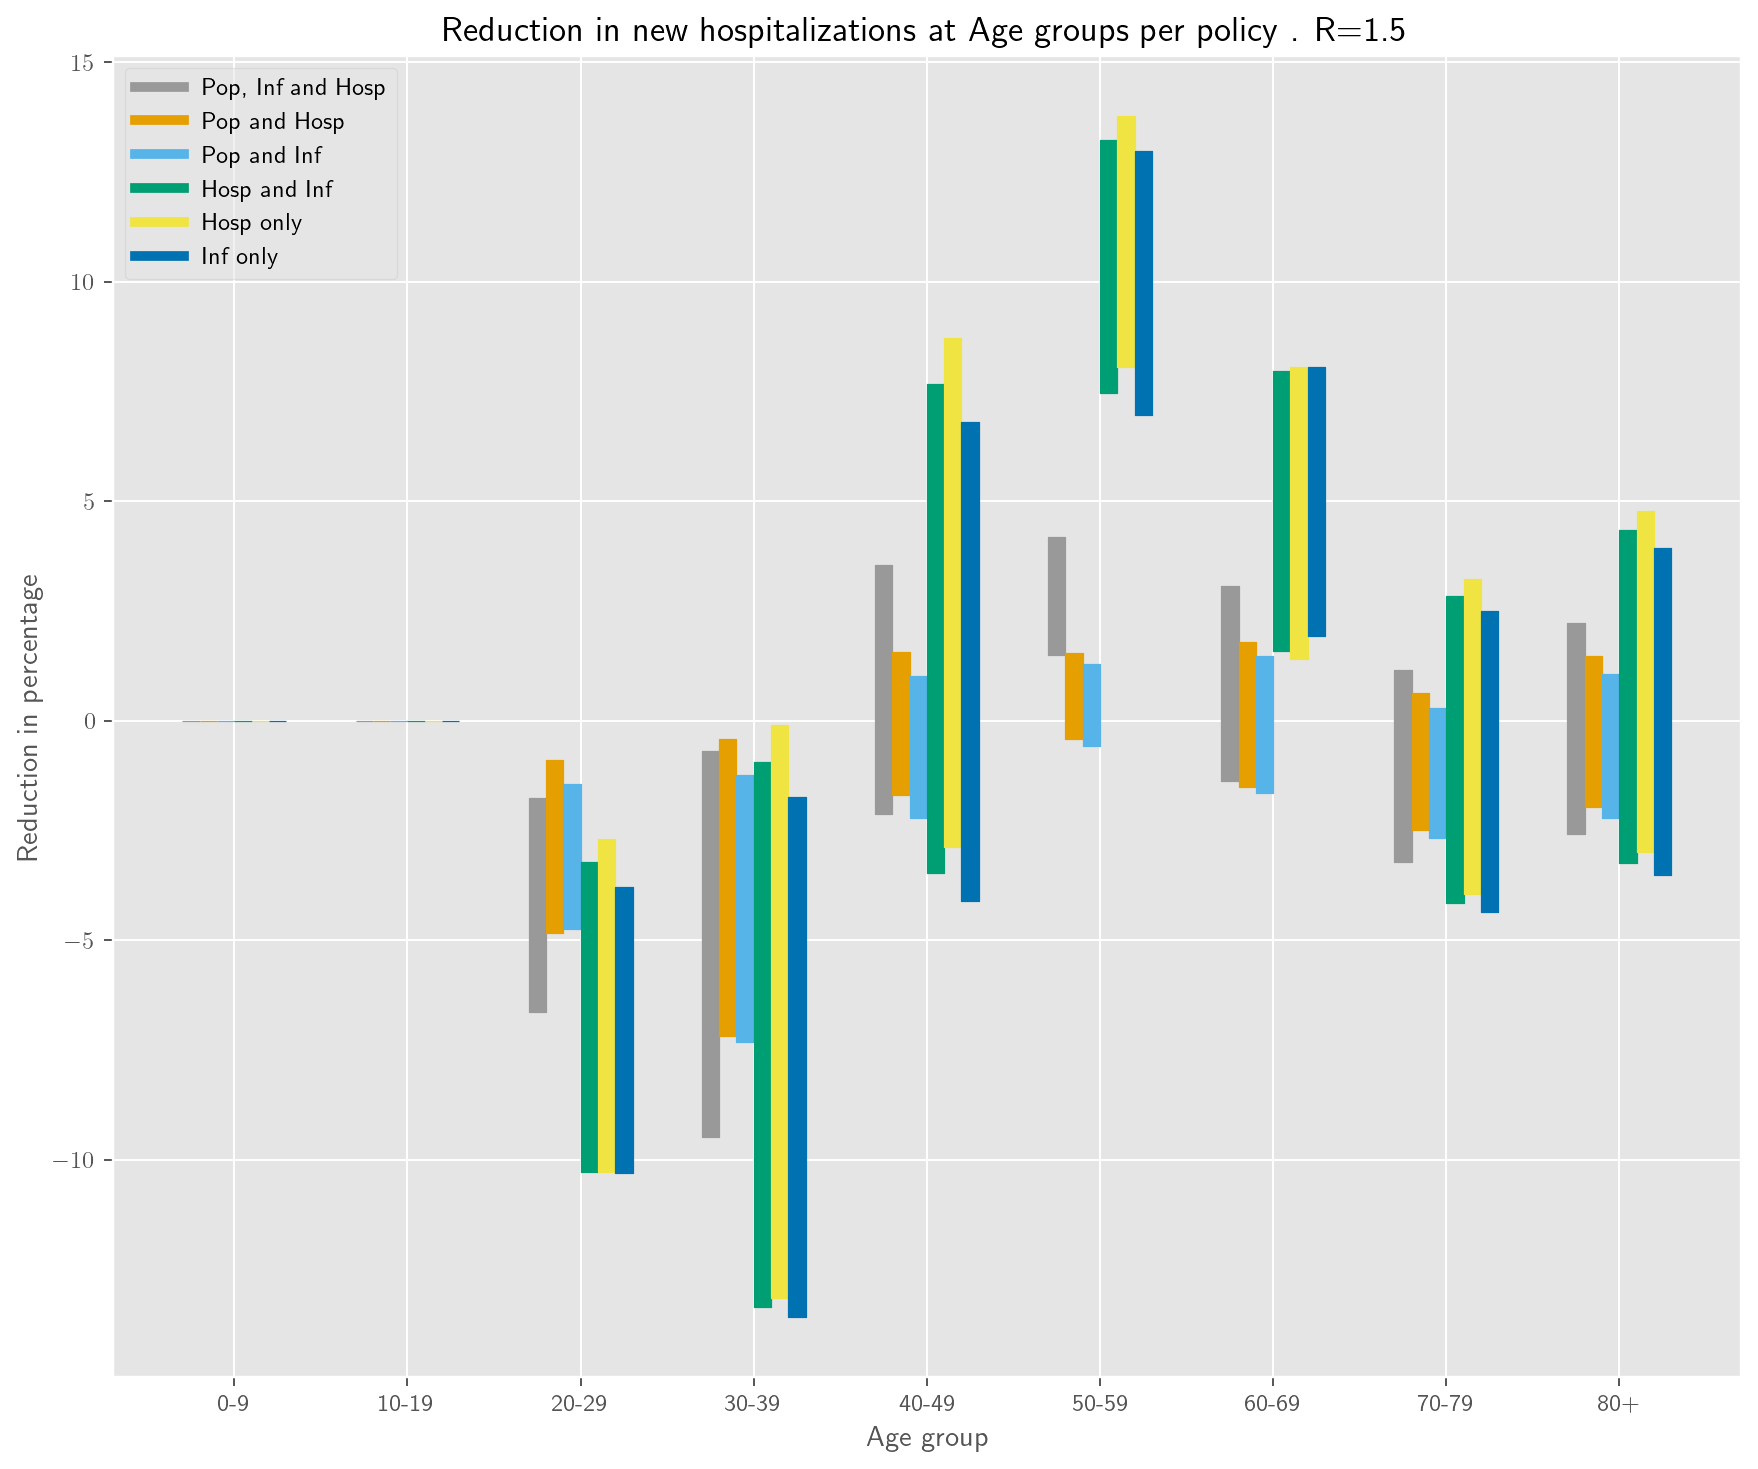

In [8]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r=1.5, tau=0.5, metric='new hospitalizations', exp_results=exp_results, labels=age_labels,
                          plot='Age group', t2=t2, t1=t1, baseline='Pop only', skip_no_vacc=True)

# Infections

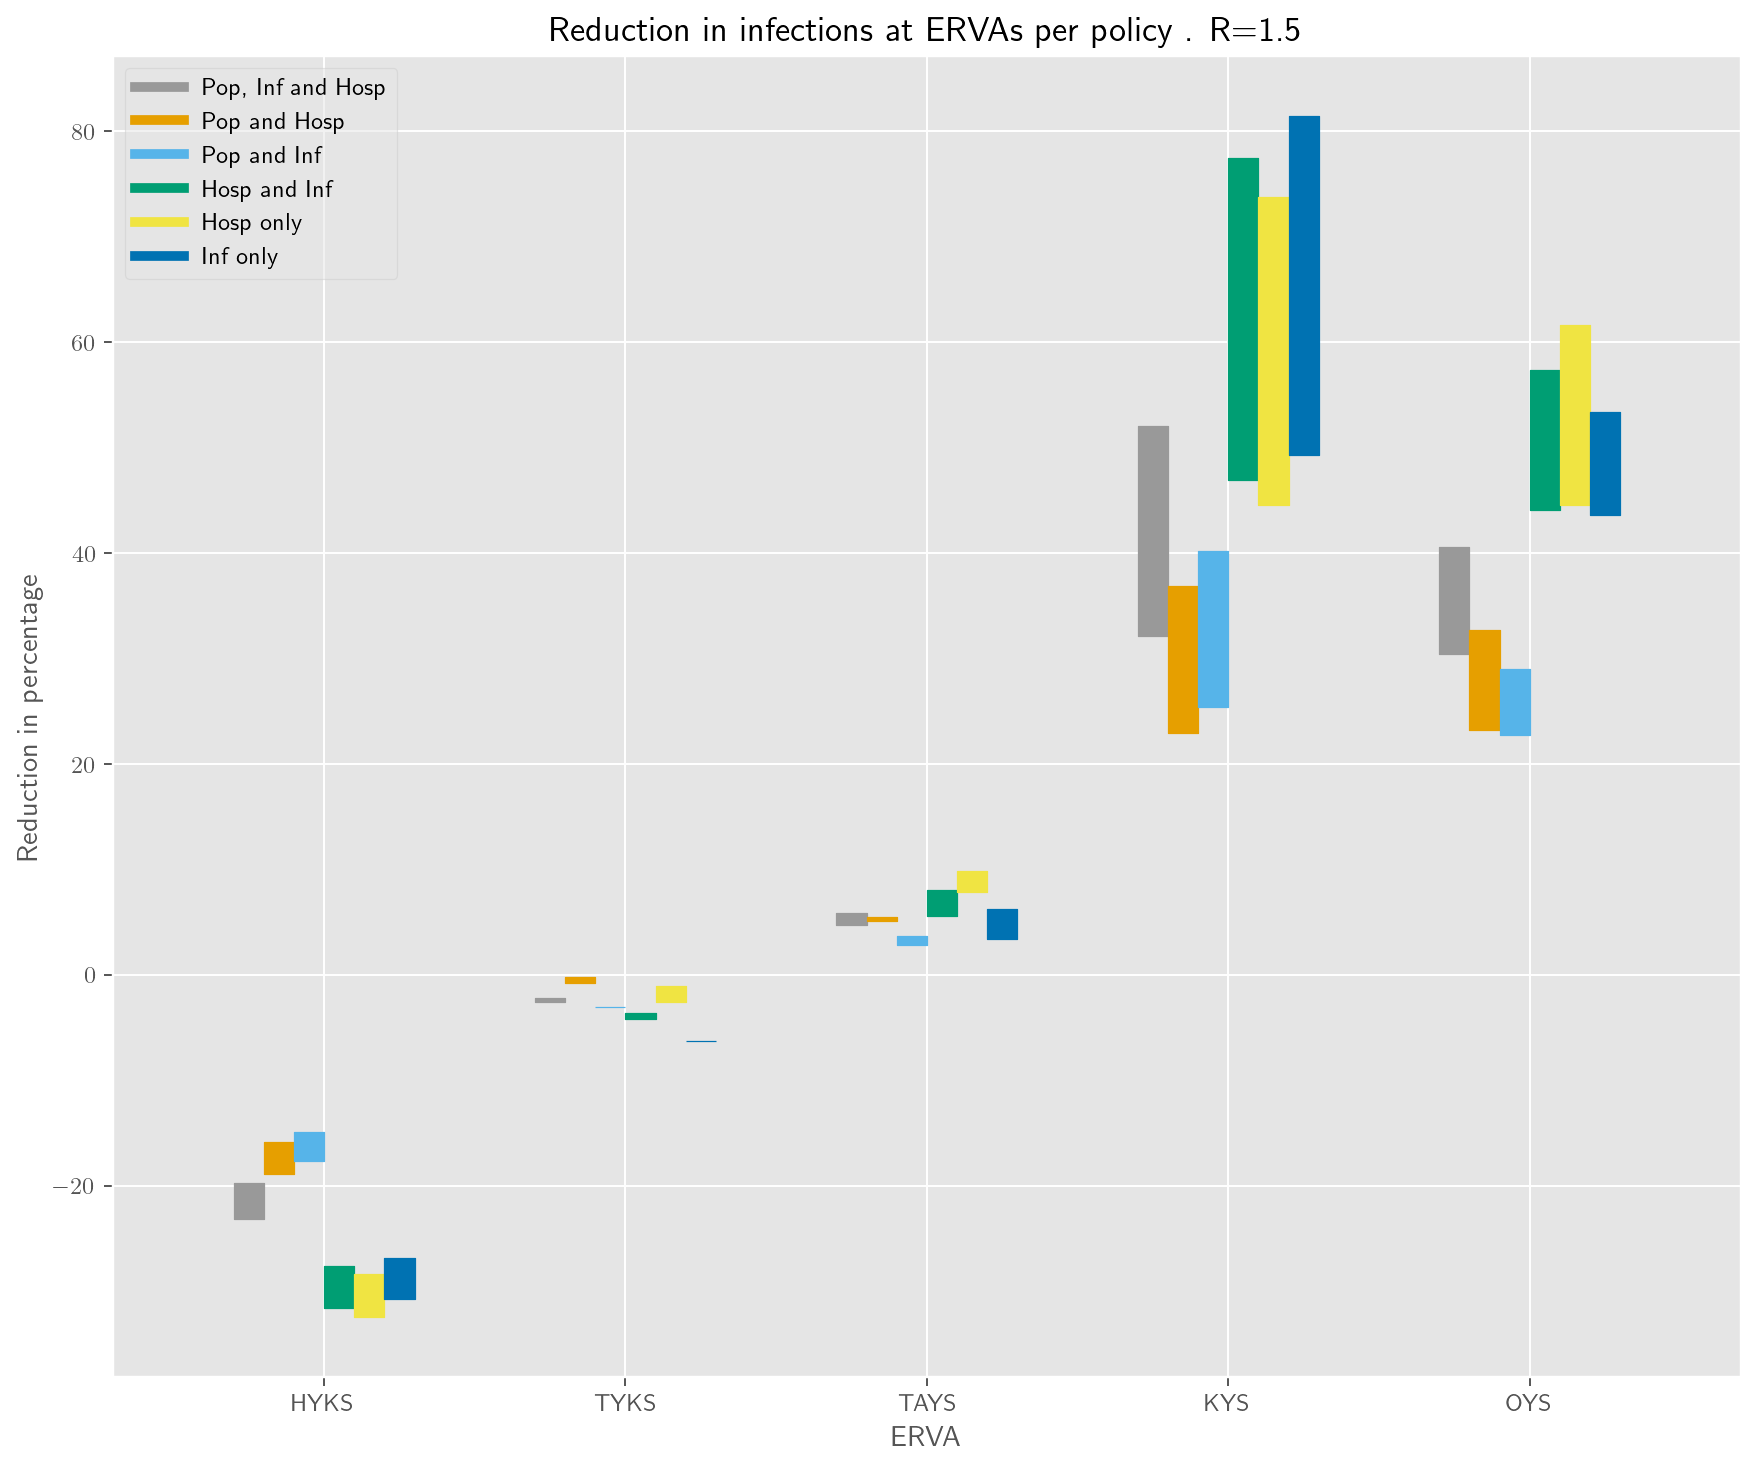

In [9]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r=1.5, tau=0.5, metric='infections', exp_results=exp_results, labels=ervas_labels,
                          plot='ERVA', t2=t2, t1=t1, baseline='Pop only', skip_no_vacc=True)

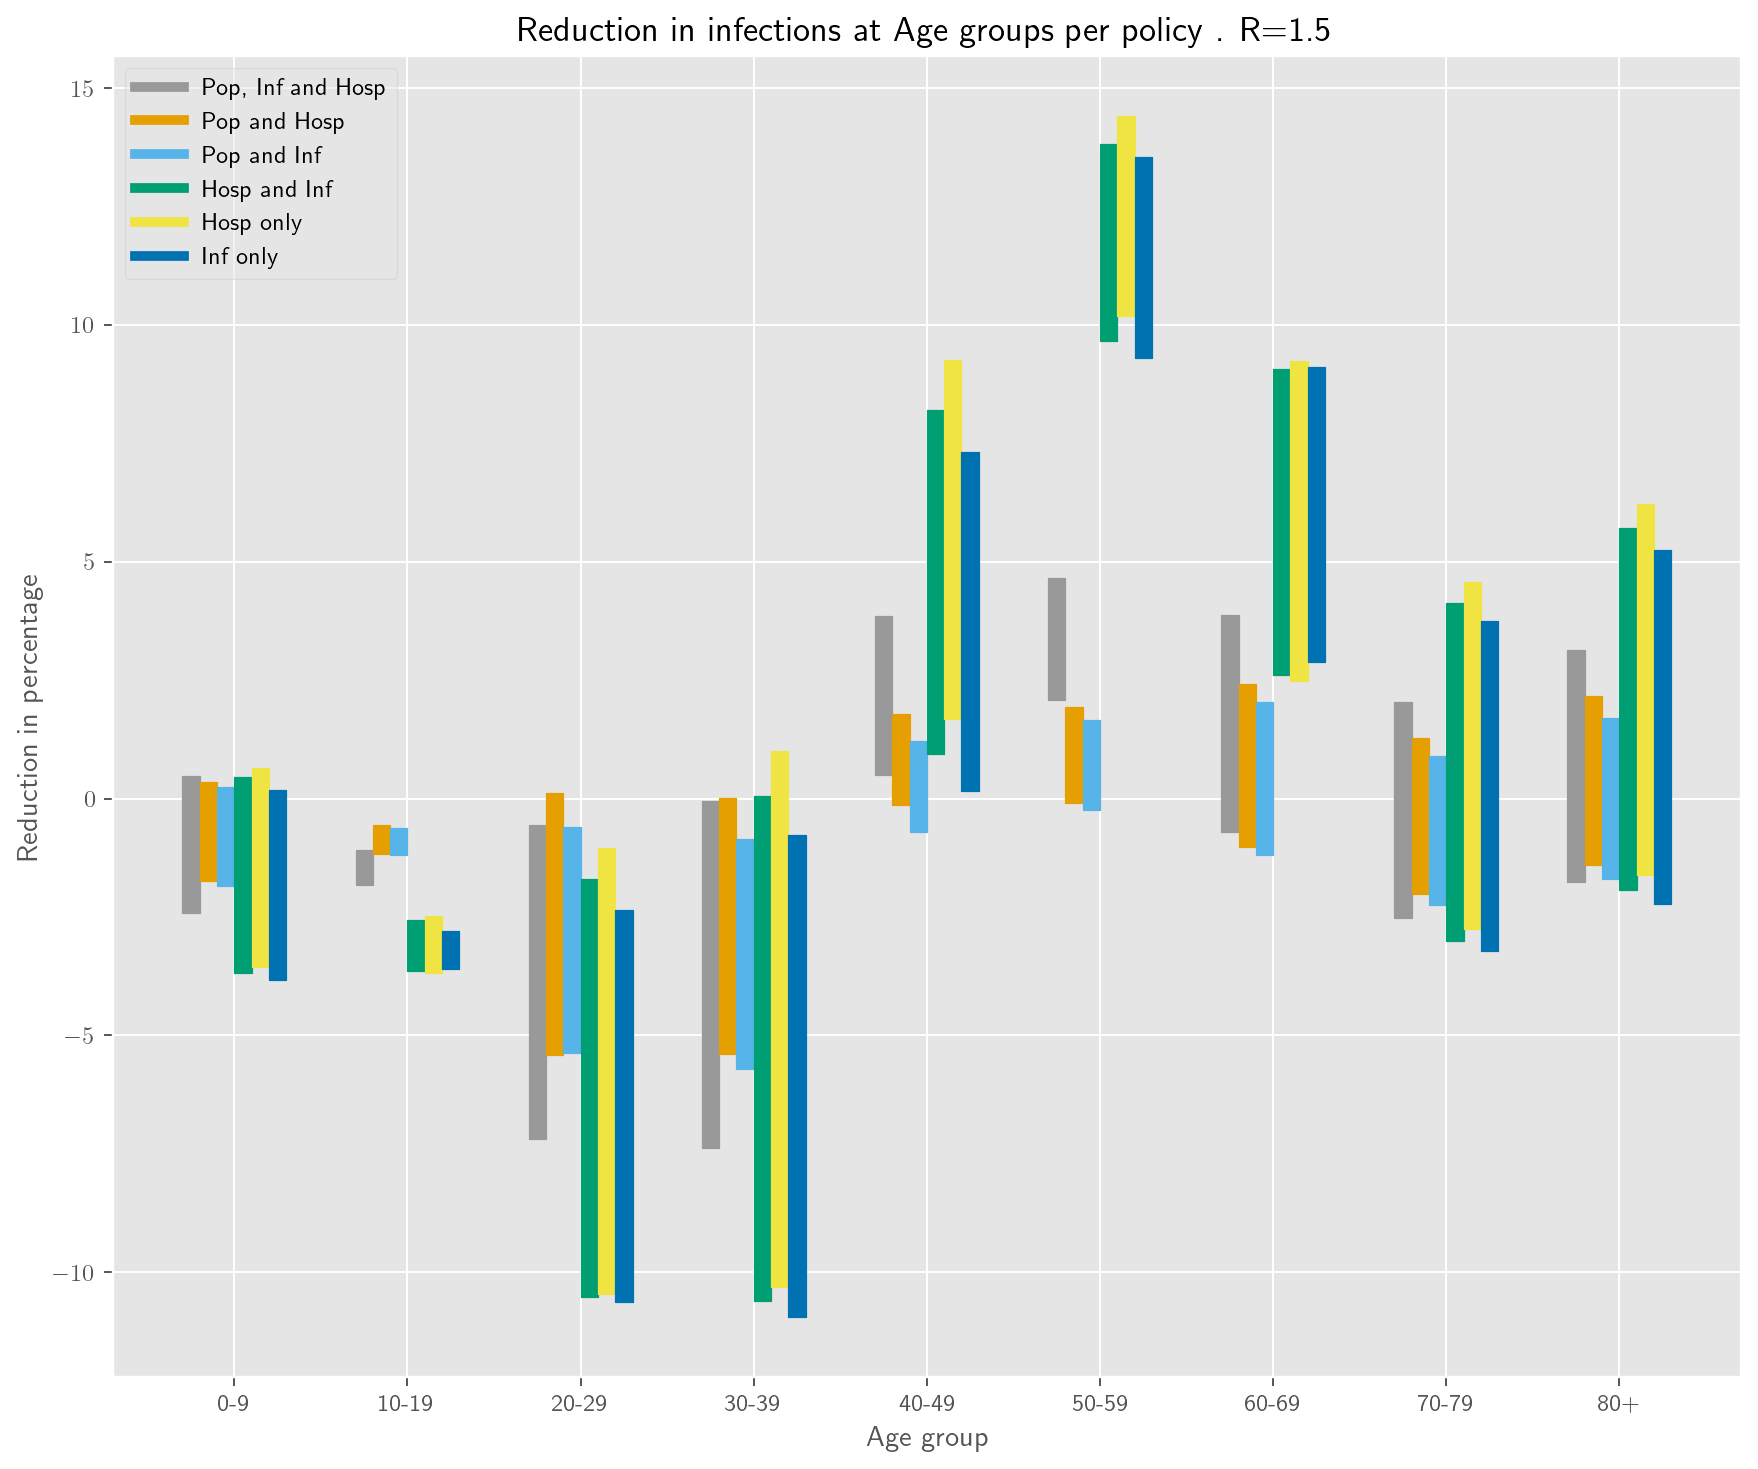

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_bars_ages_ervas(ax, r=1.5, tau=0.5, metric='infections', exp_results=exp_results, labels=age_labels,
                          plot='Age group', t2=t2, t1=t1, baseline='Pop only', skip_no_vacc=True)

# Saving figures and generating latex

In [11]:
def save_and_generate_latex(r_experiments, taus, ervas_labels, age_labels, metrics, exp_results, dpis,
                            skip_no_vacc, img_dir, t2, t1, baseline, file_format, latex_template):
    os.makedirs(img_dir, exist_ok=True)
    # Iterate over all results
    for r in r_experiments:
        for tau in taus:
            for metric in metrics:
                fig, axs = plt.subplots(2, 1, figsize=(11, 15))
                axs = axs.flat
                # Plot one figure for ERVA and one for age group per r, tau pair
                for plot, labels, ax in zip(['ERVA', 'Age group'], [ervas_labels, age_labels], axs):
                    ax = plot_bars_ages_ervas(ax=ax, r=r, tau=tau, metric=metric, plot=plot,
                                              exp_results=exp_results, labels=labels, t2=t2, t1=t1,
                                              baseline=baseline, skip_no_vacc=skip_no_vacc)
                    ax.set_ylabel('')
                    ax.set_title('%ss' % (plot, ))
                # Setting the labels for the current figure
                fig.suptitle('Relative change in %s wrt strategy %s.\n'
                             '$R_0=%s. \\tau=%s$' % (metric, baseline, r, tau), fontsize=16)
                y_lab = 'Change in percentage (\%)'
                fig.text(0.04, 0.5, y_lab, va='center', rotation='vertical', fontsize=16)
                # Saving the figure
                name = 'bars_r%s_tau%s_metric_%s' % (r, tau, metric)
                fig_name = name + '.' + file_format 
                fig_path = os.path.join(img_dir, fig_name)
                fig.savefig(fig_path, format=file_format, dpi=dpis, bbox_inches='tight')
                # Constructing Latex code for the current figure and printing it
                latext_text = latex_template.format(fig_name=fig_name,
                                                    metric=metric,
                                                    baseline=baseline,
                                                    name=name,
                                                    r=r,
                                                    tau=tau)
                print(latext_text)

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide



    \begin{figure}[p]
      \centering
      \includegraphics[width=\textwidth]{img/bars_r0.75_tau0.5_metric_deaths.pdf}
      \caption{Relative change in deaths for all vaccination strategies with respect to vaccination strategy Pop only.
      The bars represent the relative change in cumulative deaths between the end of the simulation and 30 days before the end of the simulation.
      For this scenario, the basic reproduction number $R_0 = 0.75$ and the mobility value $\tau = 0.5$.
      Top: Relative change at ERVA level, Bottom: Relative change at age group level.}
      \label{fig:bars_r0.75_tau0.5_metric_deaths}
    \end{figure}



/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide



    \begin{figure}[p]
      \centering
      \includegraphics[width=\textwidth]{img/bars_r0.75_tau0.5_metric_new hospitalizations.pdf}
      \caption{Relative change in new hospitalizations for all vaccination strategies with respect to vaccination strategy Pop only.
      The bars represent the relative change in cumulative new hospitalizations between the end of the simulation and 30 days before the end of the simulation.
      For this scenario, the basic reproduction number $R_0 = 0.75$ and the mobility value $\tau = 0.5$.
      Top: Relative change at ERVA level, Bottom: Relative change at age group level.}
      \label{fig:bars_r0.75_tau0.5_metric_new hospitalizations}
    \end{figure}


    \begin{figure}[p]
      \centering
      \includegraphics[width=\textwidth]{img/bars_r0.75_tau0.5_metric_infections.pdf}
      \caption{Relative change in infections for all vaccination strategies with respect to vaccination strategy Pop only.
      The bars represent the relative change in 

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide



    \begin{figure}[p]
      \centering
      \includegraphics[width=\textwidth]{img/bars_r1.0_tau0.5_metric_deaths.pdf}
      \caption{Relative change in deaths for all vaccination strategies with respect to vaccination strategy Pop only.
      The bars represent the relative change in cumulative deaths between the end of the simulation and 30 days before the end of the simulation.
      For this scenario, the basic reproduction number $R_0 = 1.0$ and the mobility value $\tau = 0.5$.
      Top: Relative change at ERVA level, Bottom: Relative change at age group level.}
      \label{fig:bars_r1.0_tau0.5_metric_deaths}
    \end{figure}


    \begin{figure}[p]
      \centering
      \includegraphics[width=\textwidth]{img/bars_r1.0_tau0.5_metric_new hospitalizations.pdf}
      \caption{Relative change in new hospitalizations for all vaccination strategies with respect to vaccination strategy Pop only.
      The bars represent the relative change in cumulative new hospitalizations between 

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in true_divide



    \begin{figure}[p]
      \centering
      \includegraphics[width=\textwidth]{img/bars_r1.25_tau0.5_metric_deaths.pdf}
      \caption{Relative change in deaths for all vaccination strategies with respect to vaccination strategy Pop only.
      The bars represent the relative change in cumulative deaths between the end of the simulation and 30 days before the end of the simulation.
      For this scenario, the basic reproduction number $R_0 = 1.25$ and the mobility value $\tau = 0.5$.
      Top: Relative change at ERVA level, Bottom: Relative change at age group level.}
      \label{fig:bars_r1.25_tau0.5_metric_deaths}
    \end{figure}


    \begin{figure}[p]
      \centering
      \includegraphics[width=\textwidth]{img/bars_r1.25_tau0.5_metric_new hospitalizations.pdf}
      \caption{Relative change in new hospitalizations for all vaccination strategies with respect to vaccination strategy Pop only.
      The bars represent the relative change in cumulative new hospitalizations betw

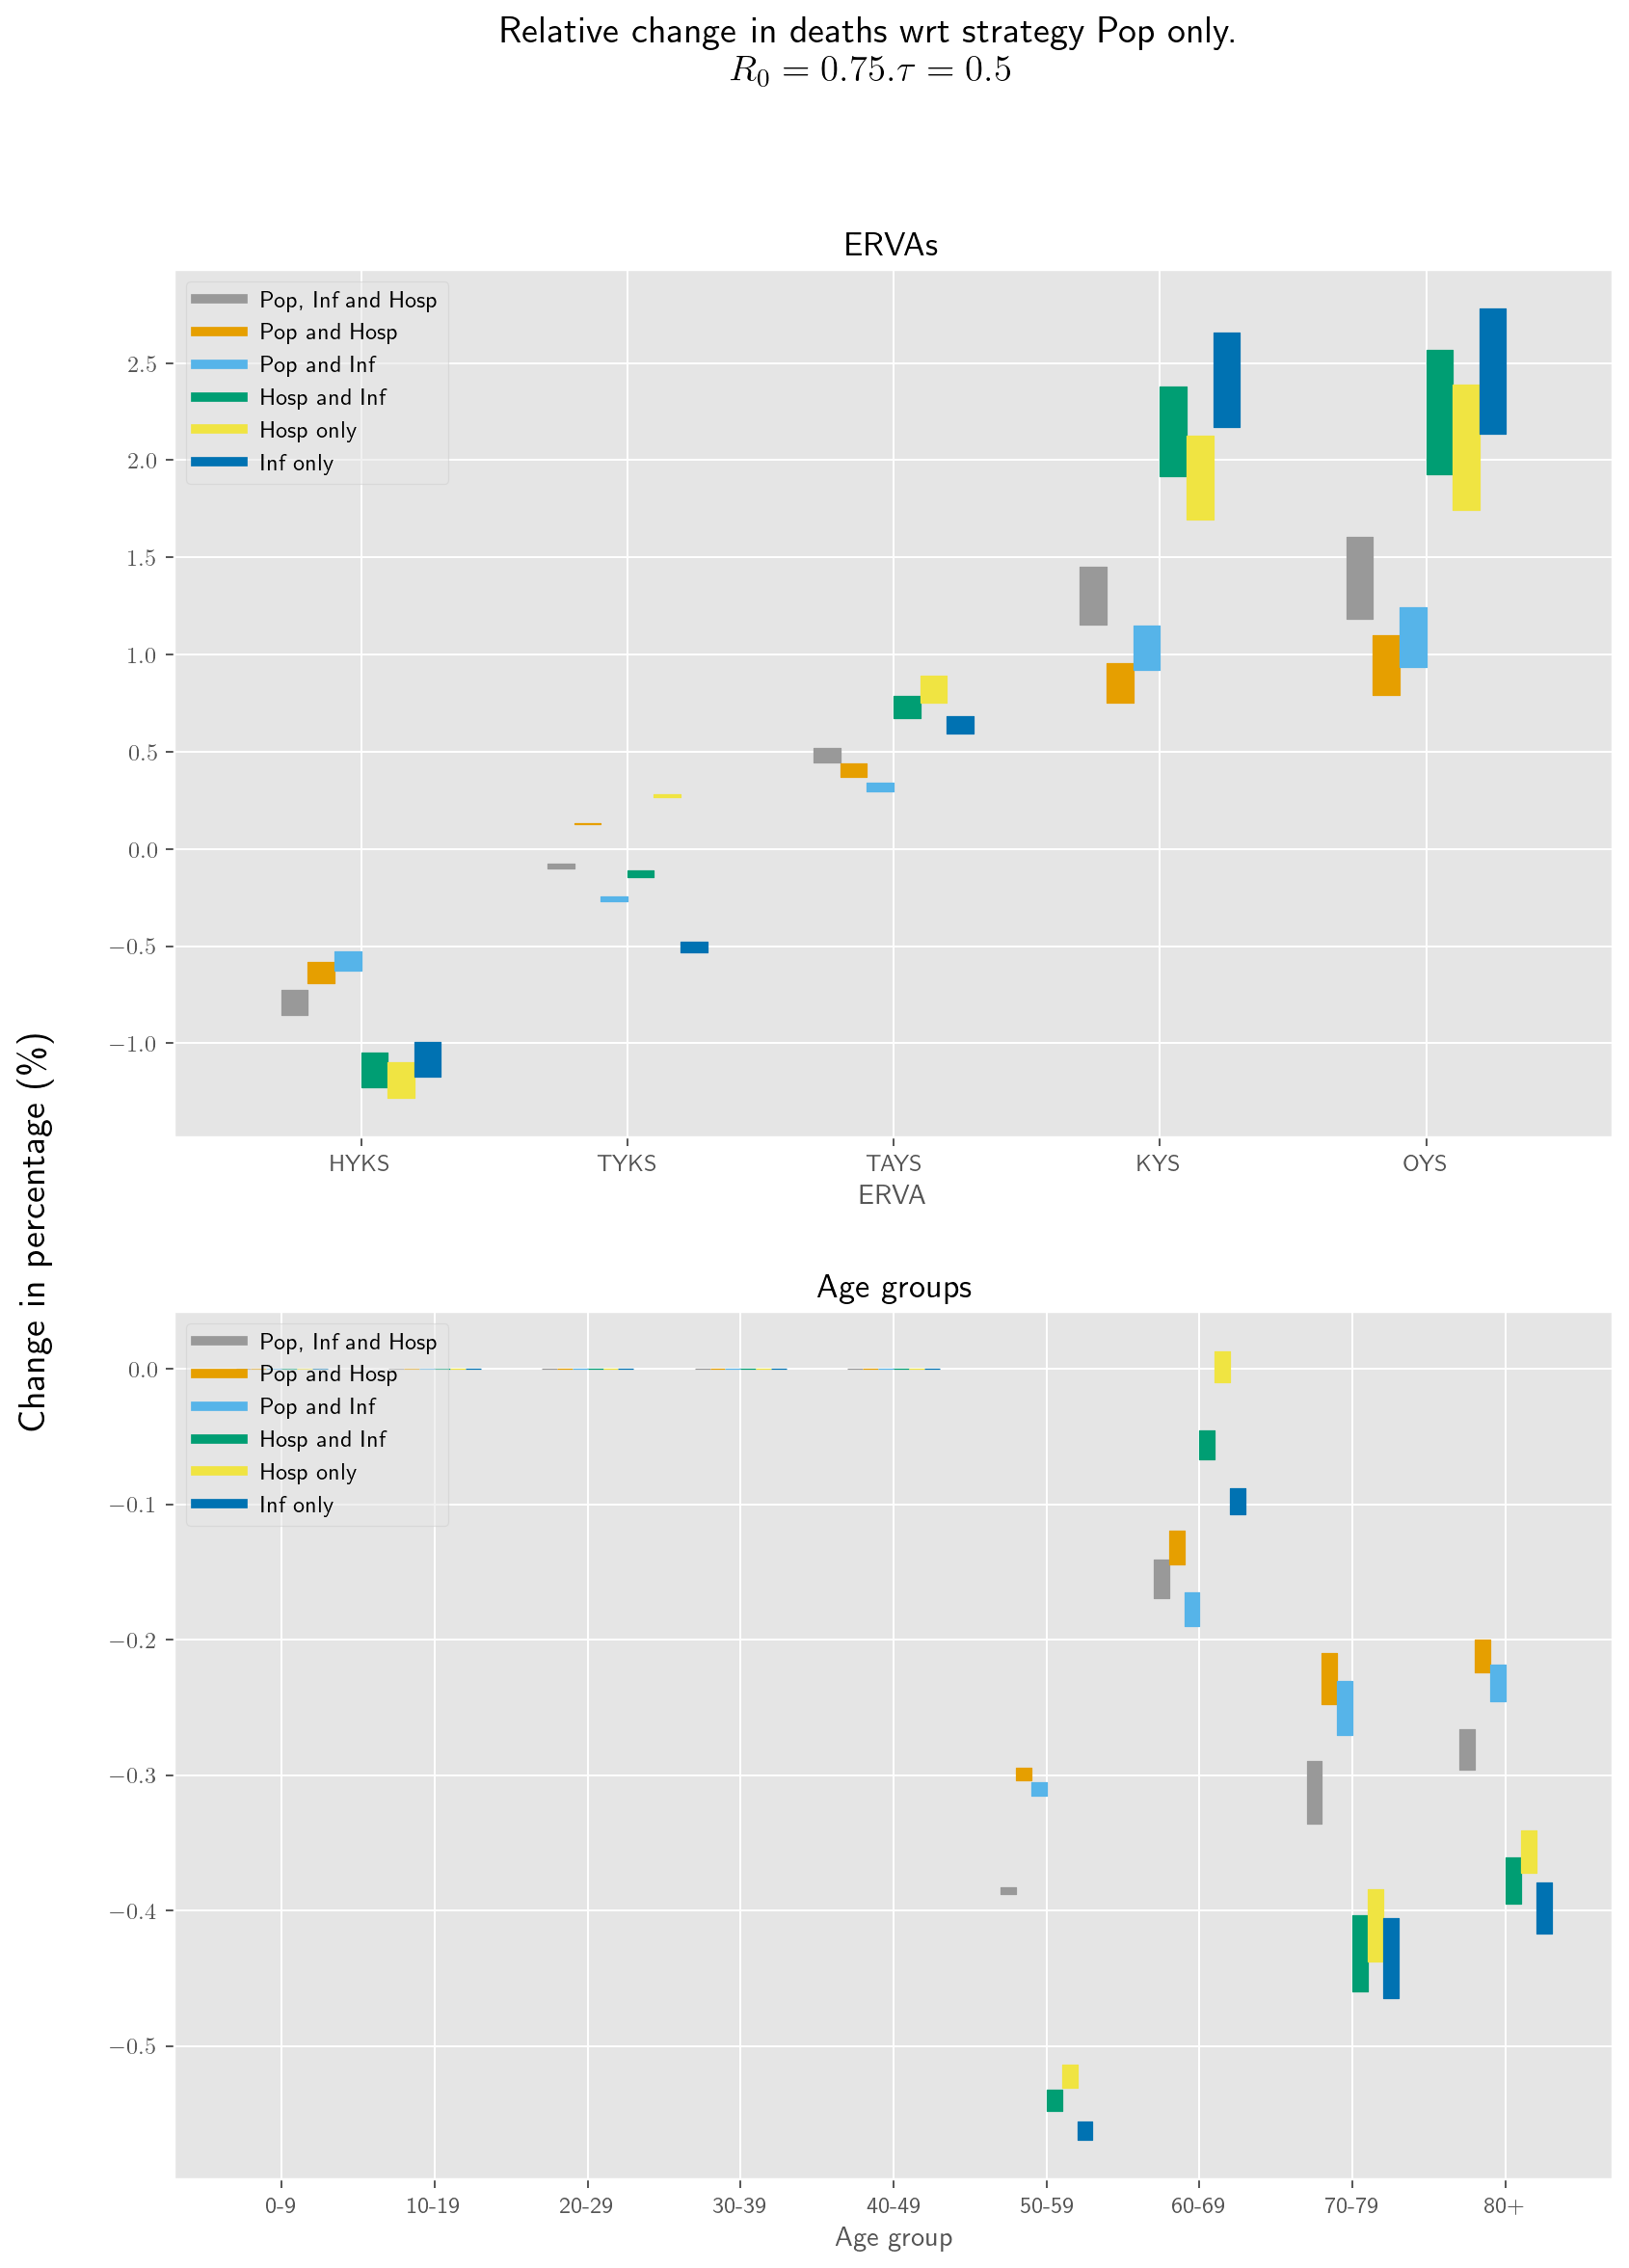

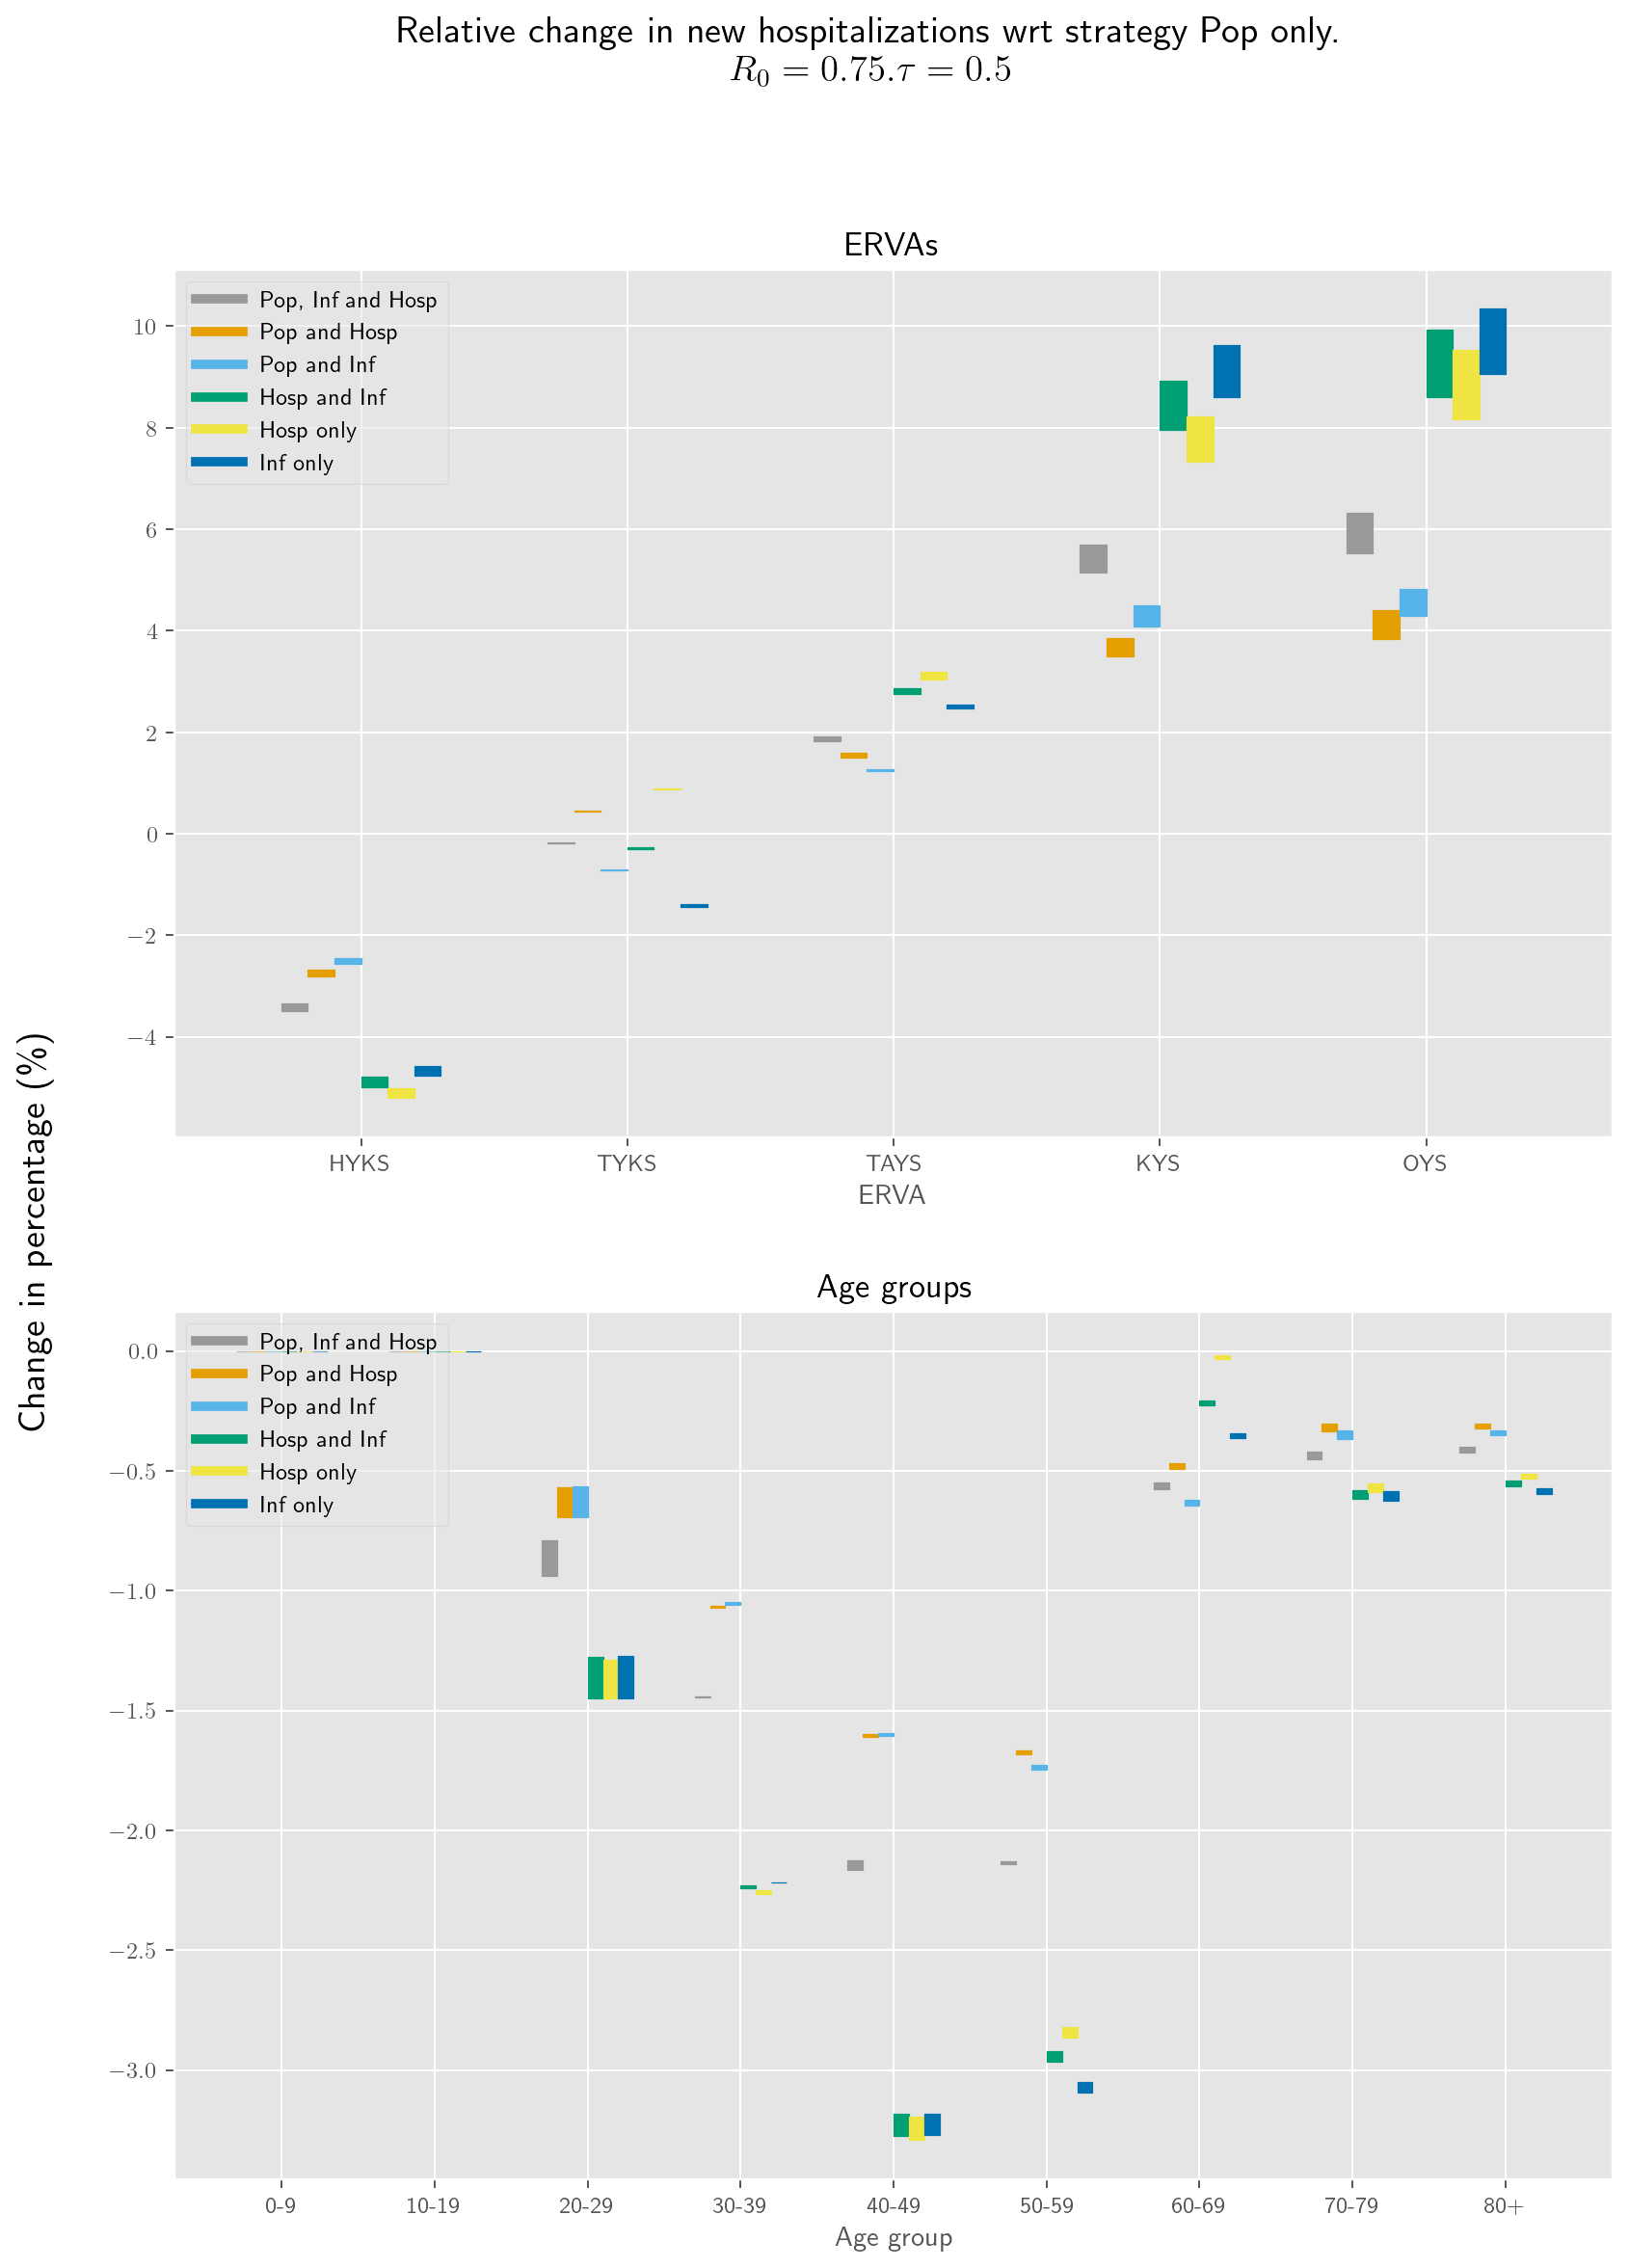

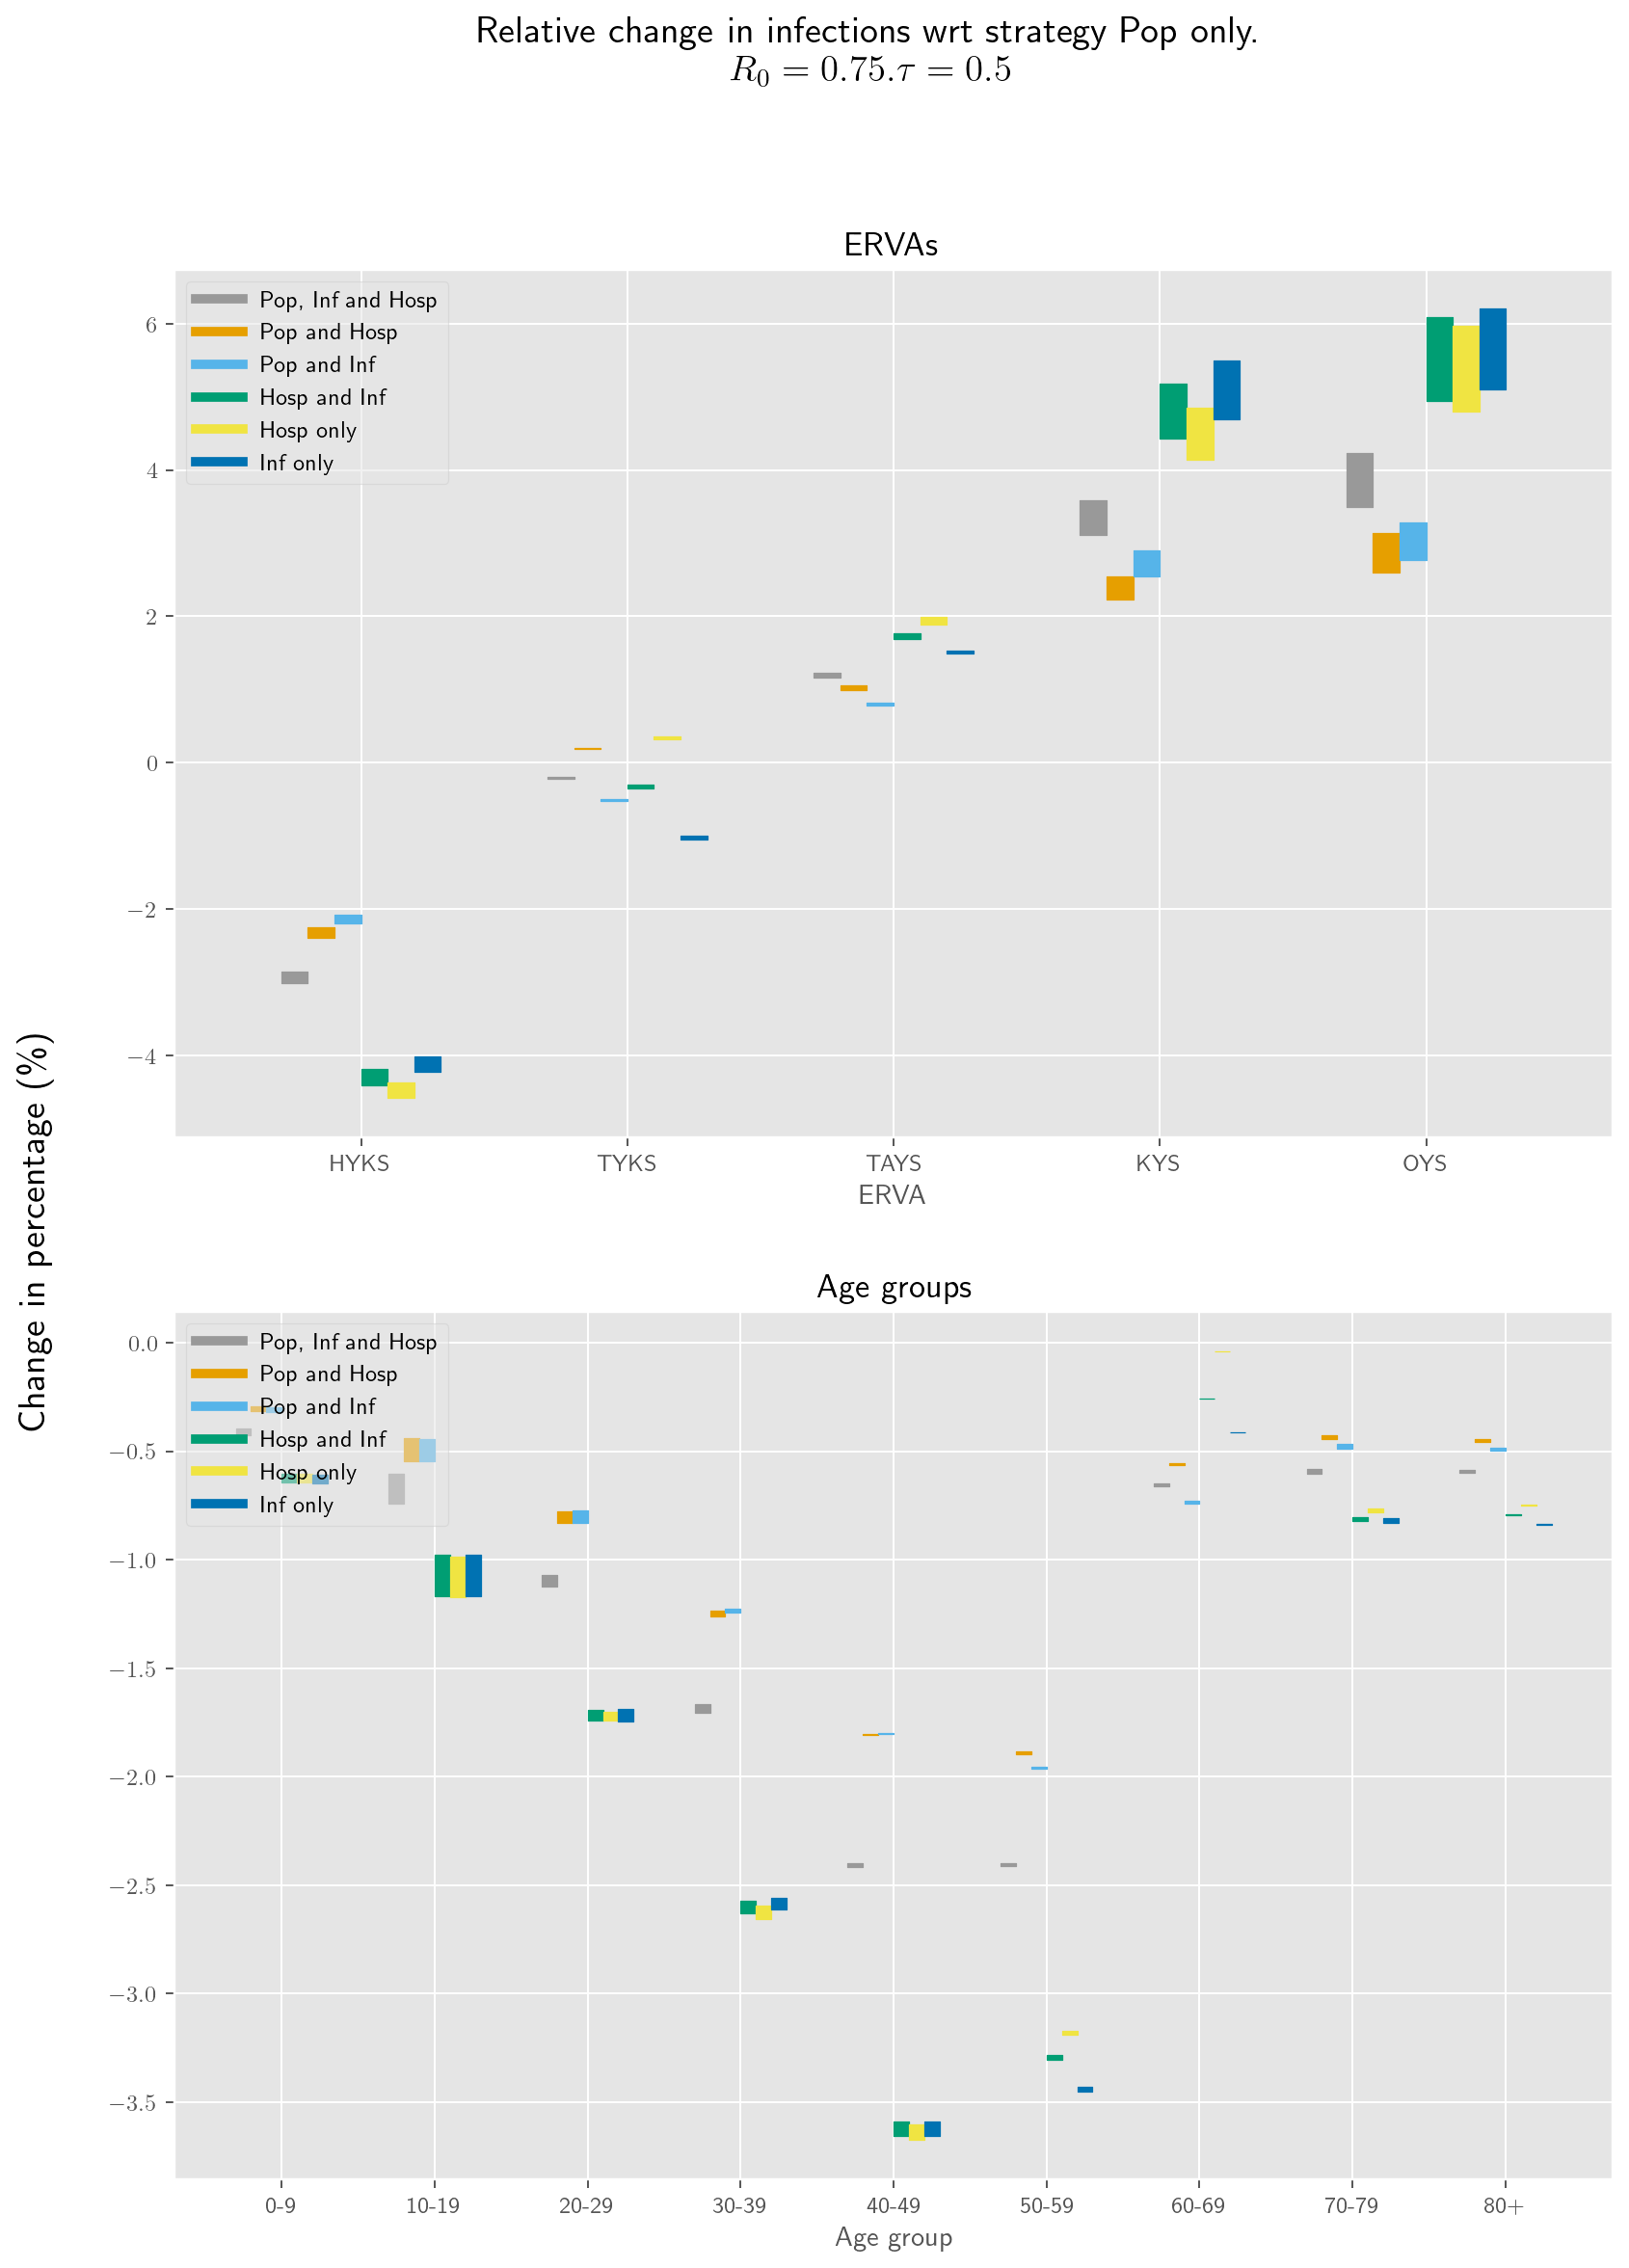

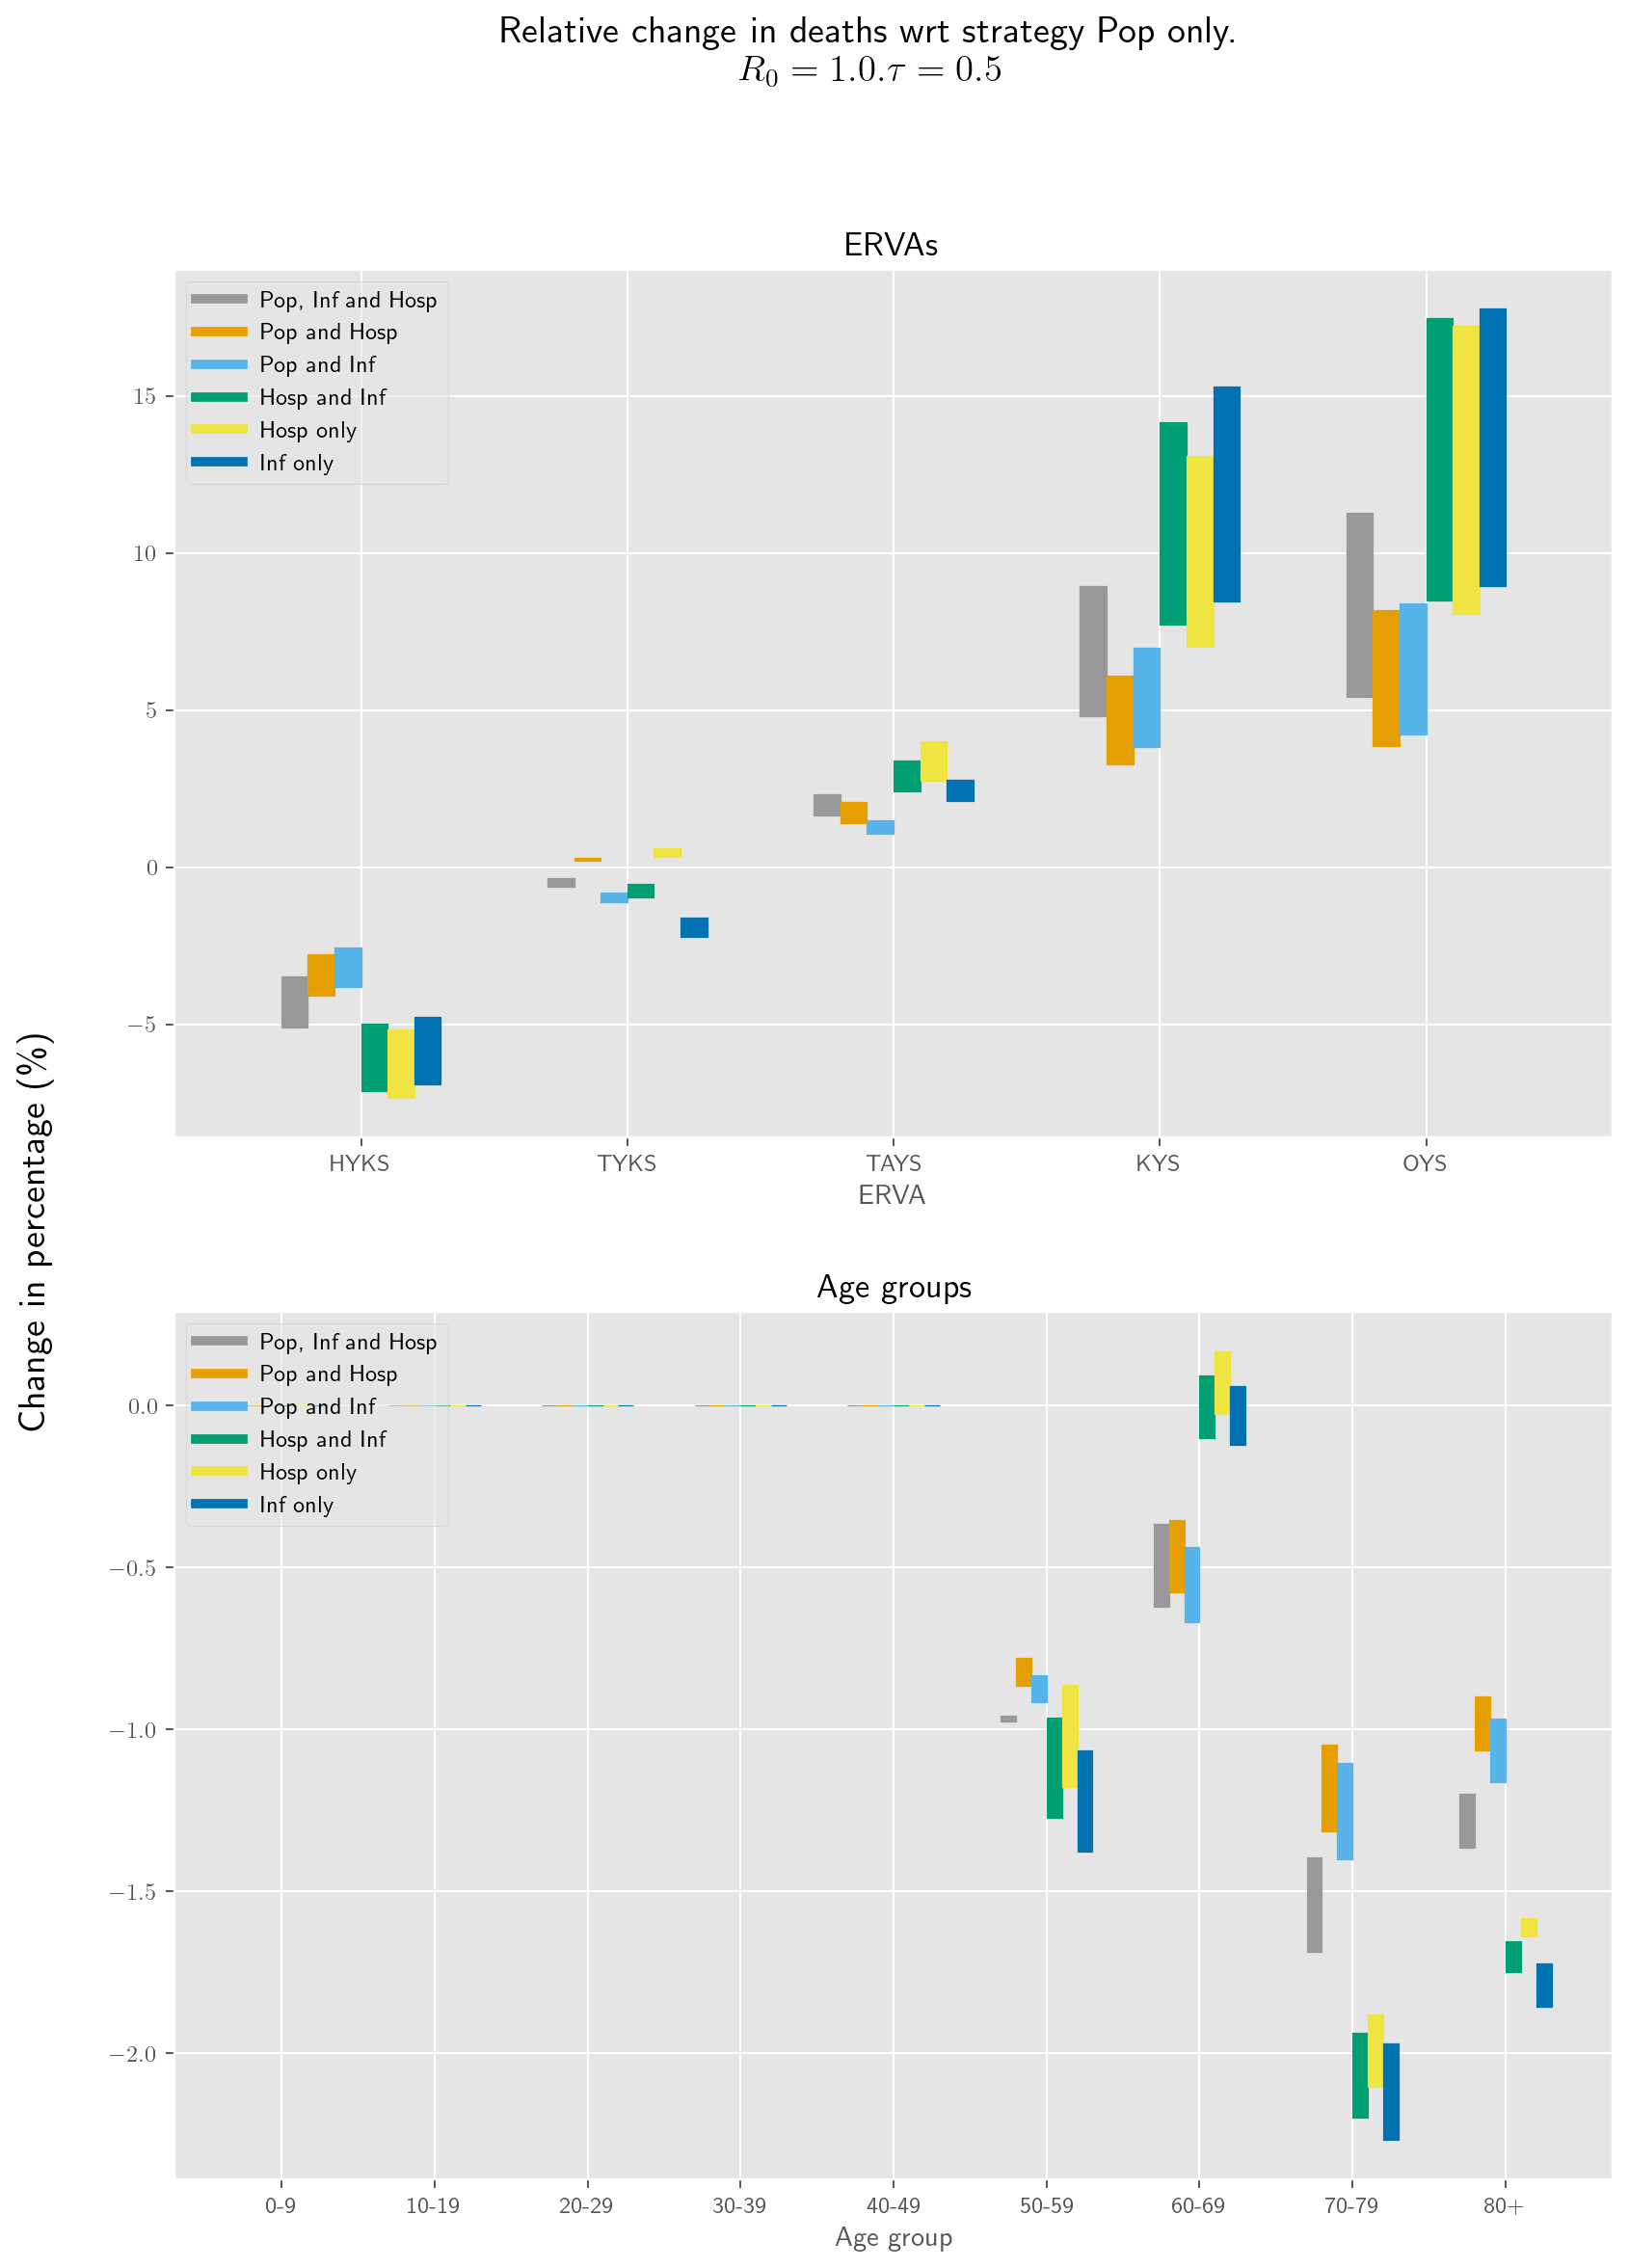

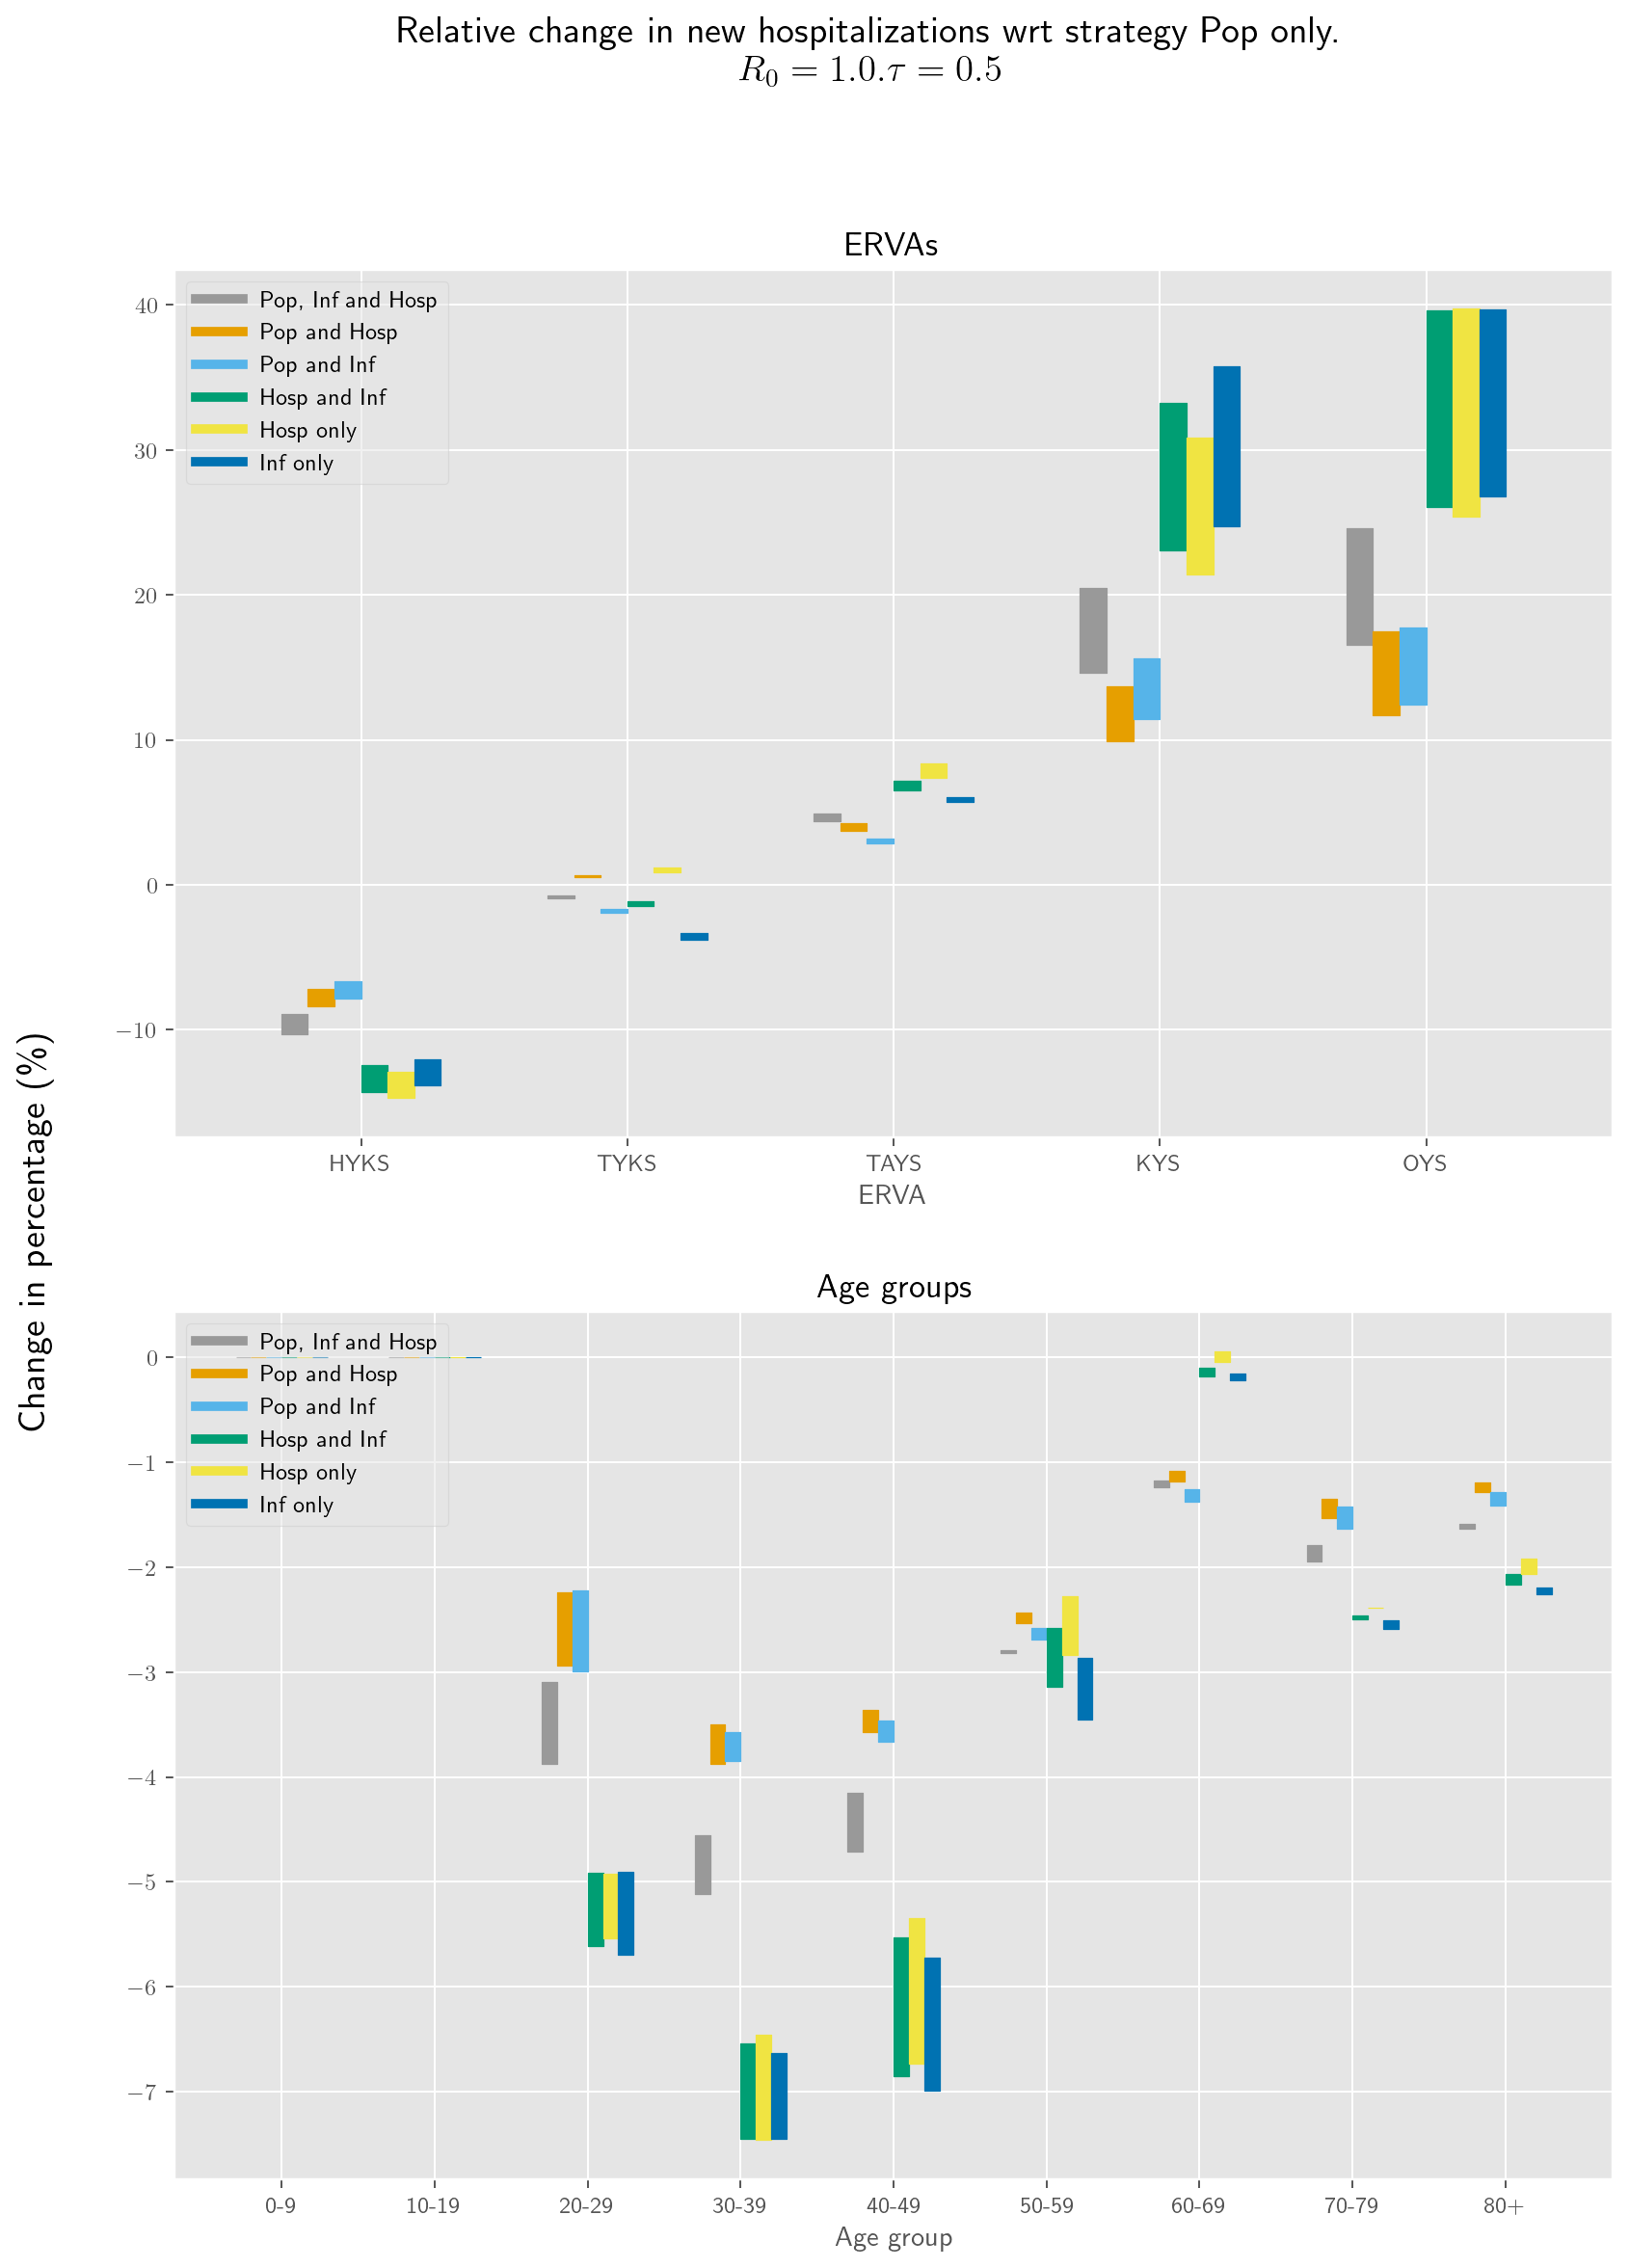

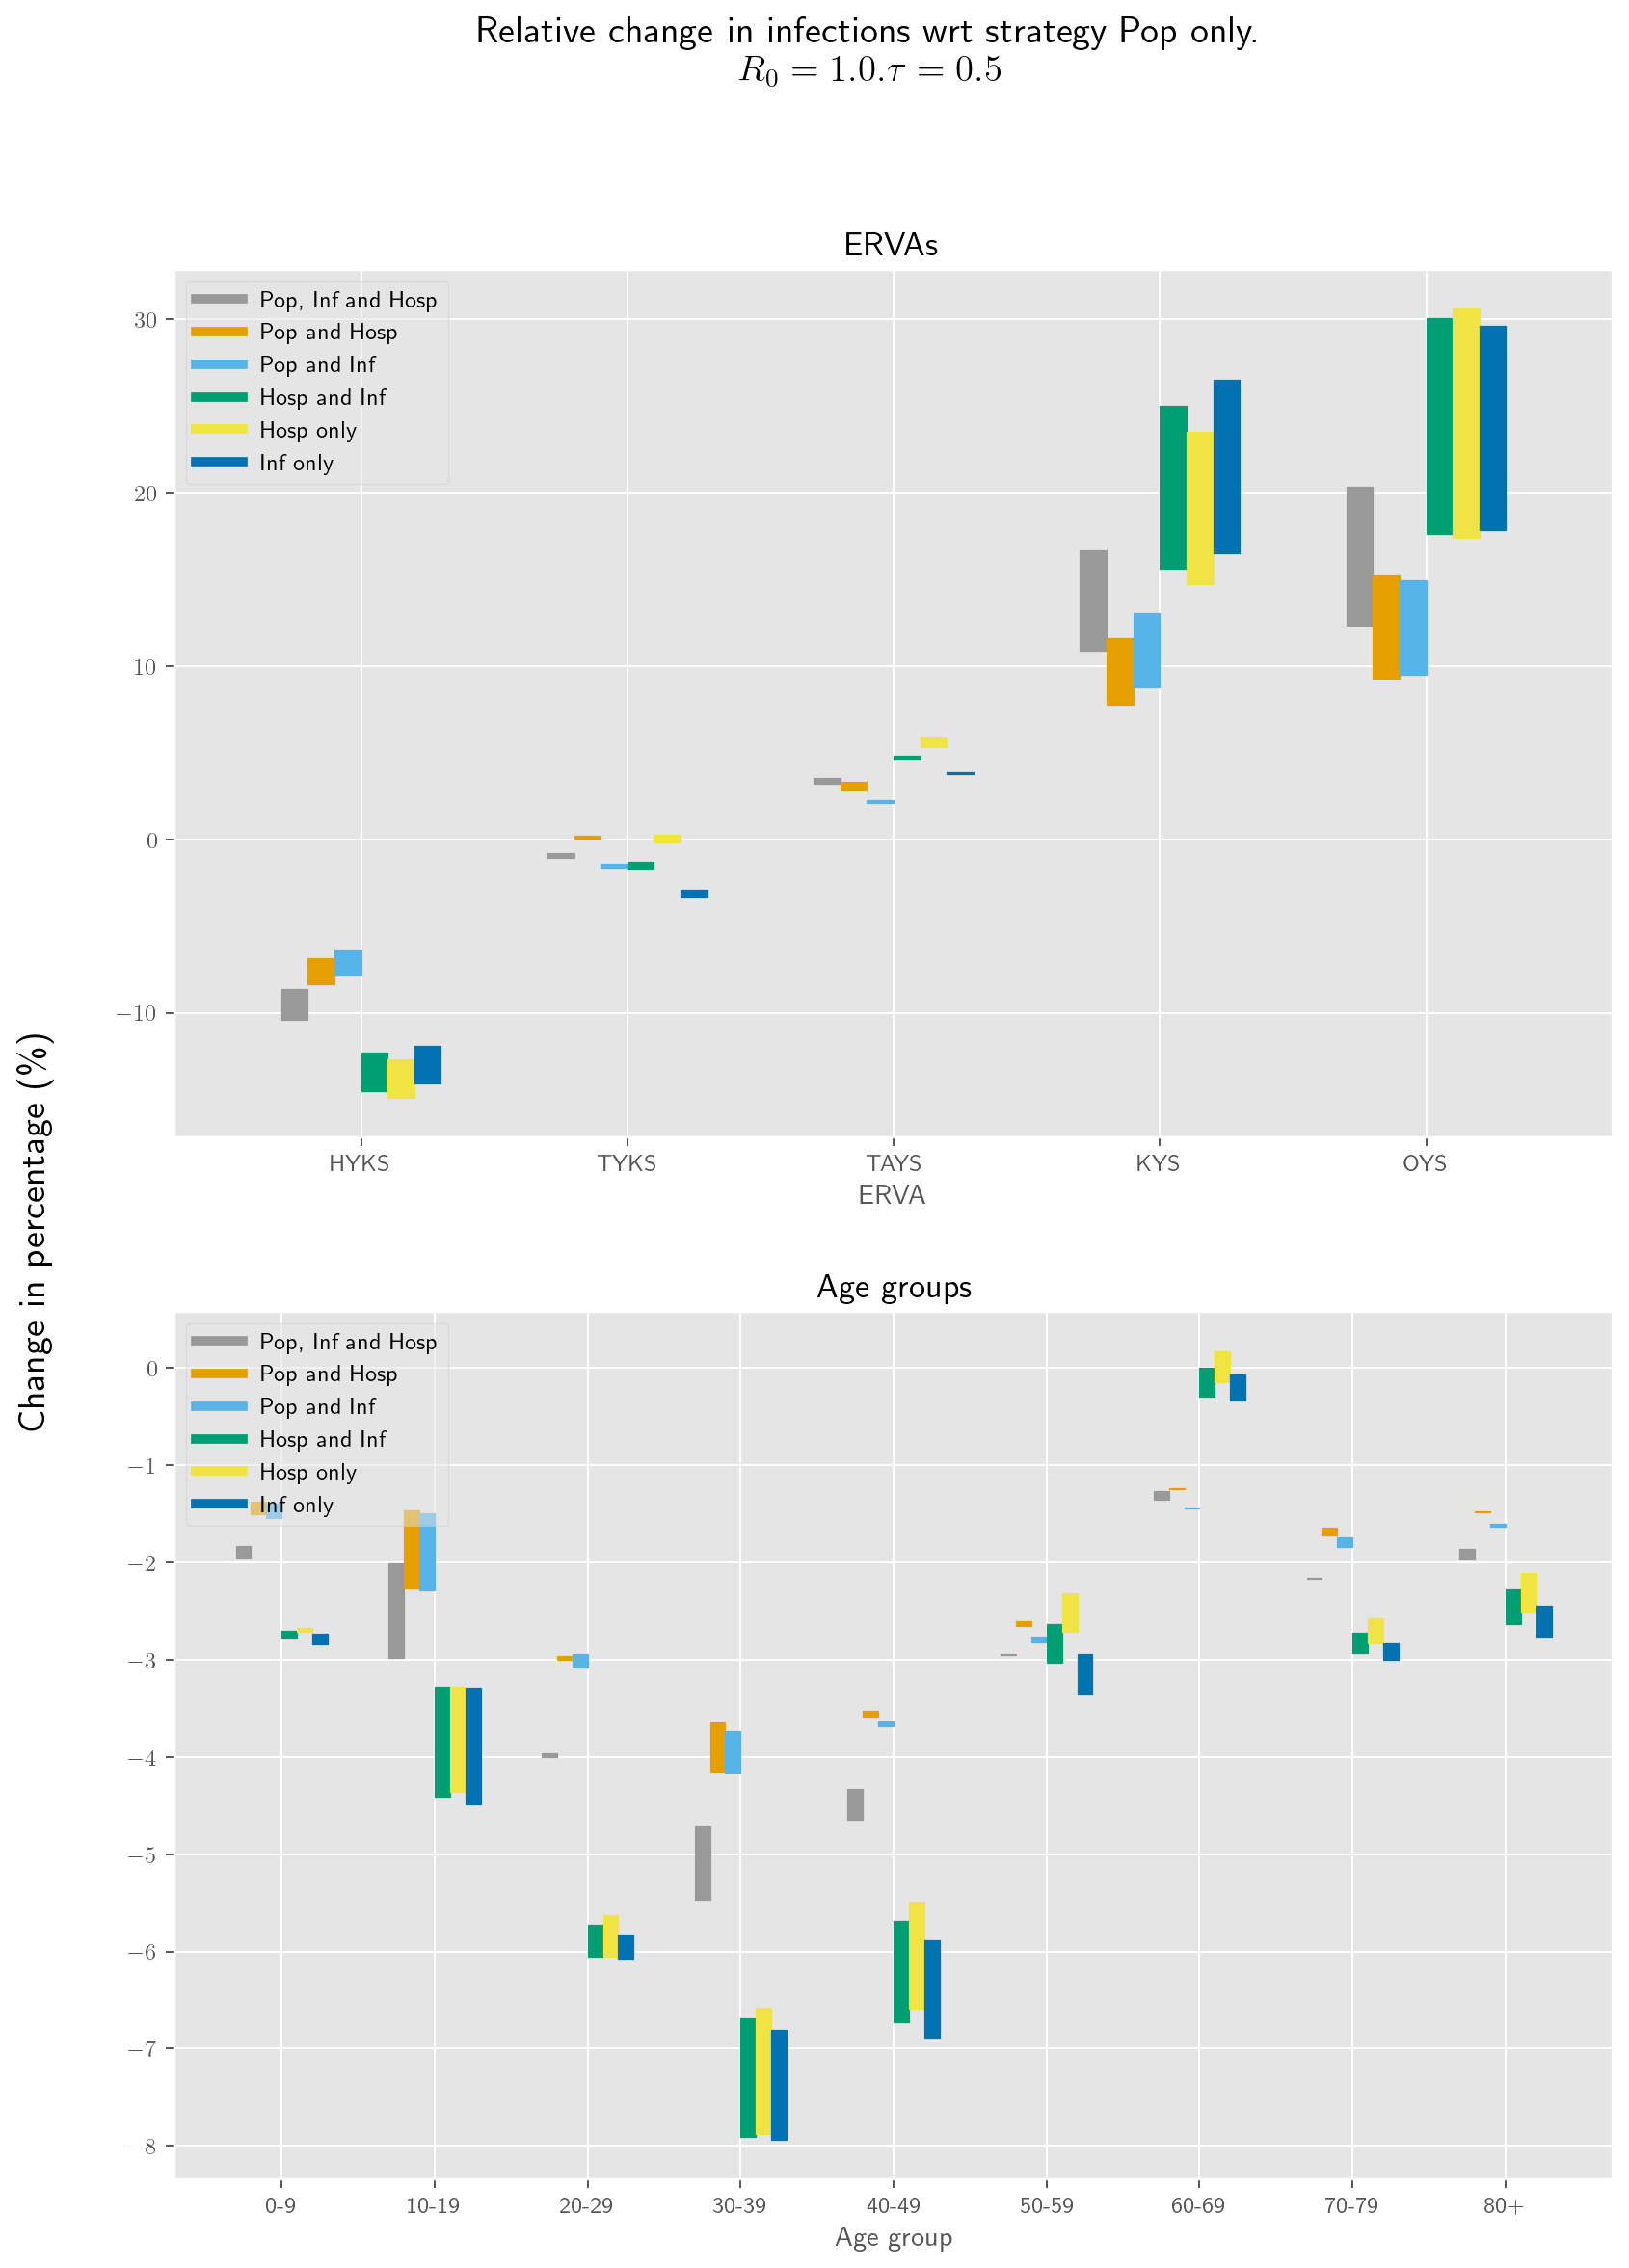

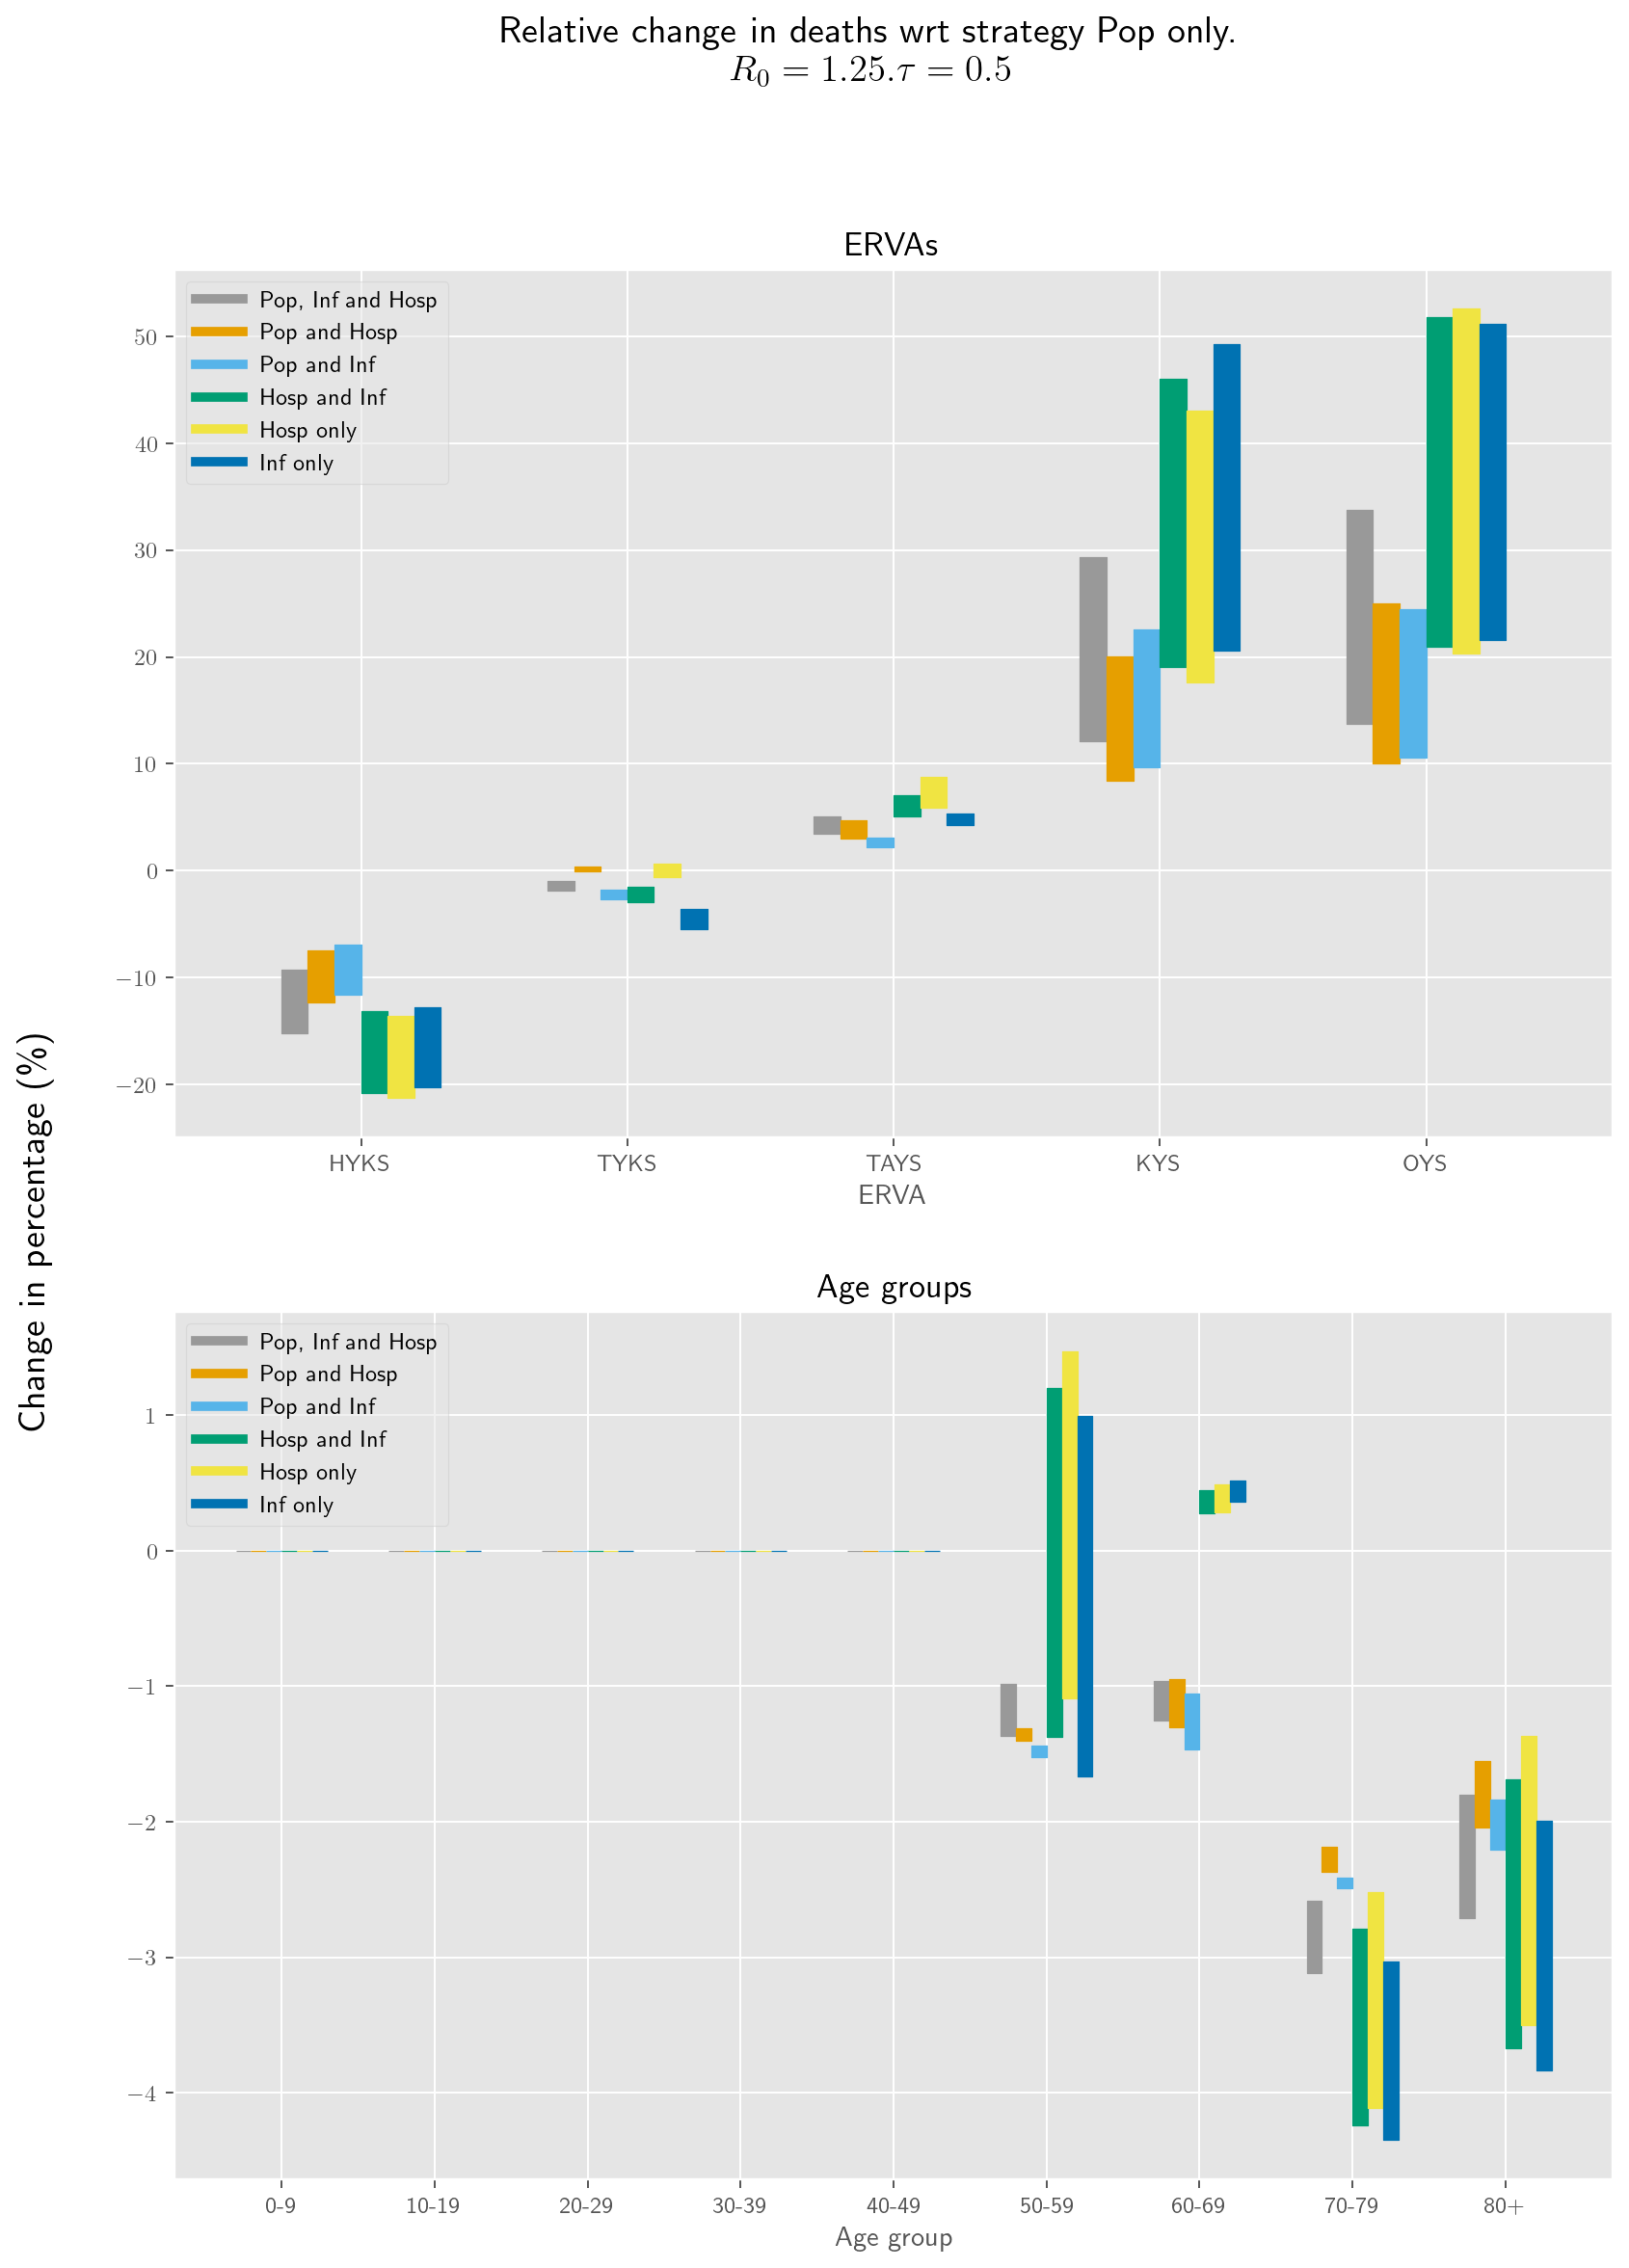

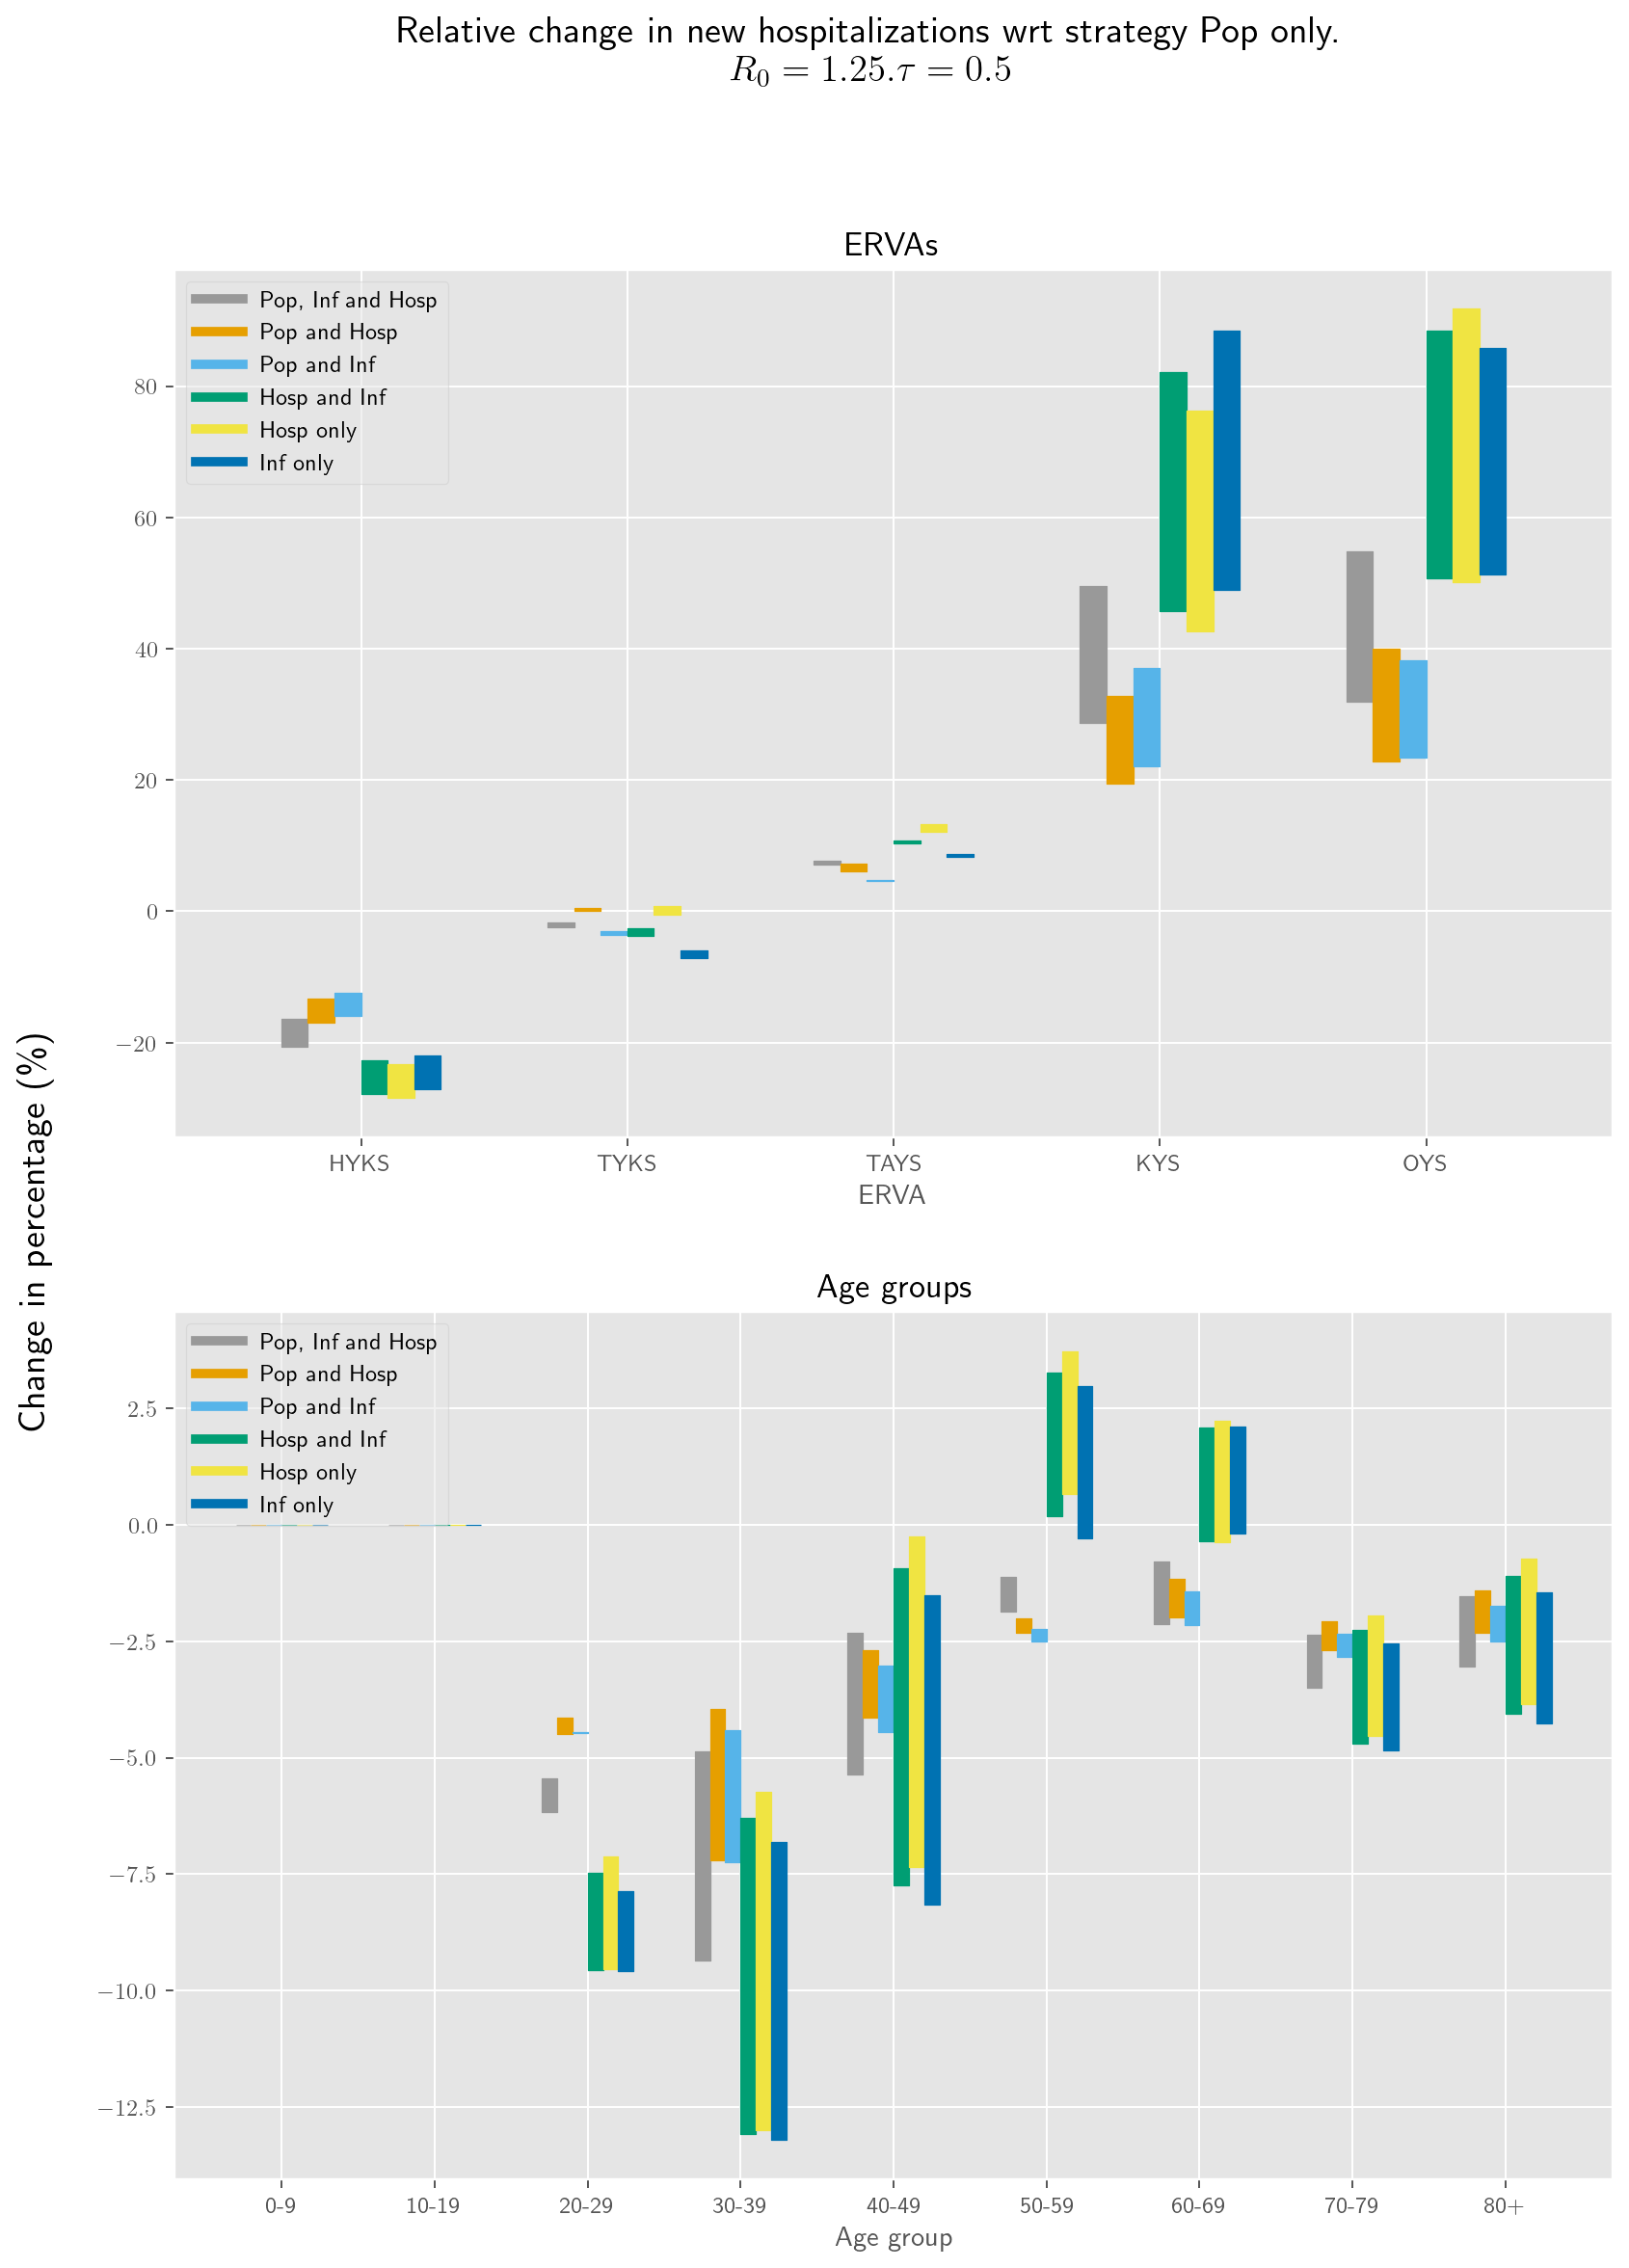

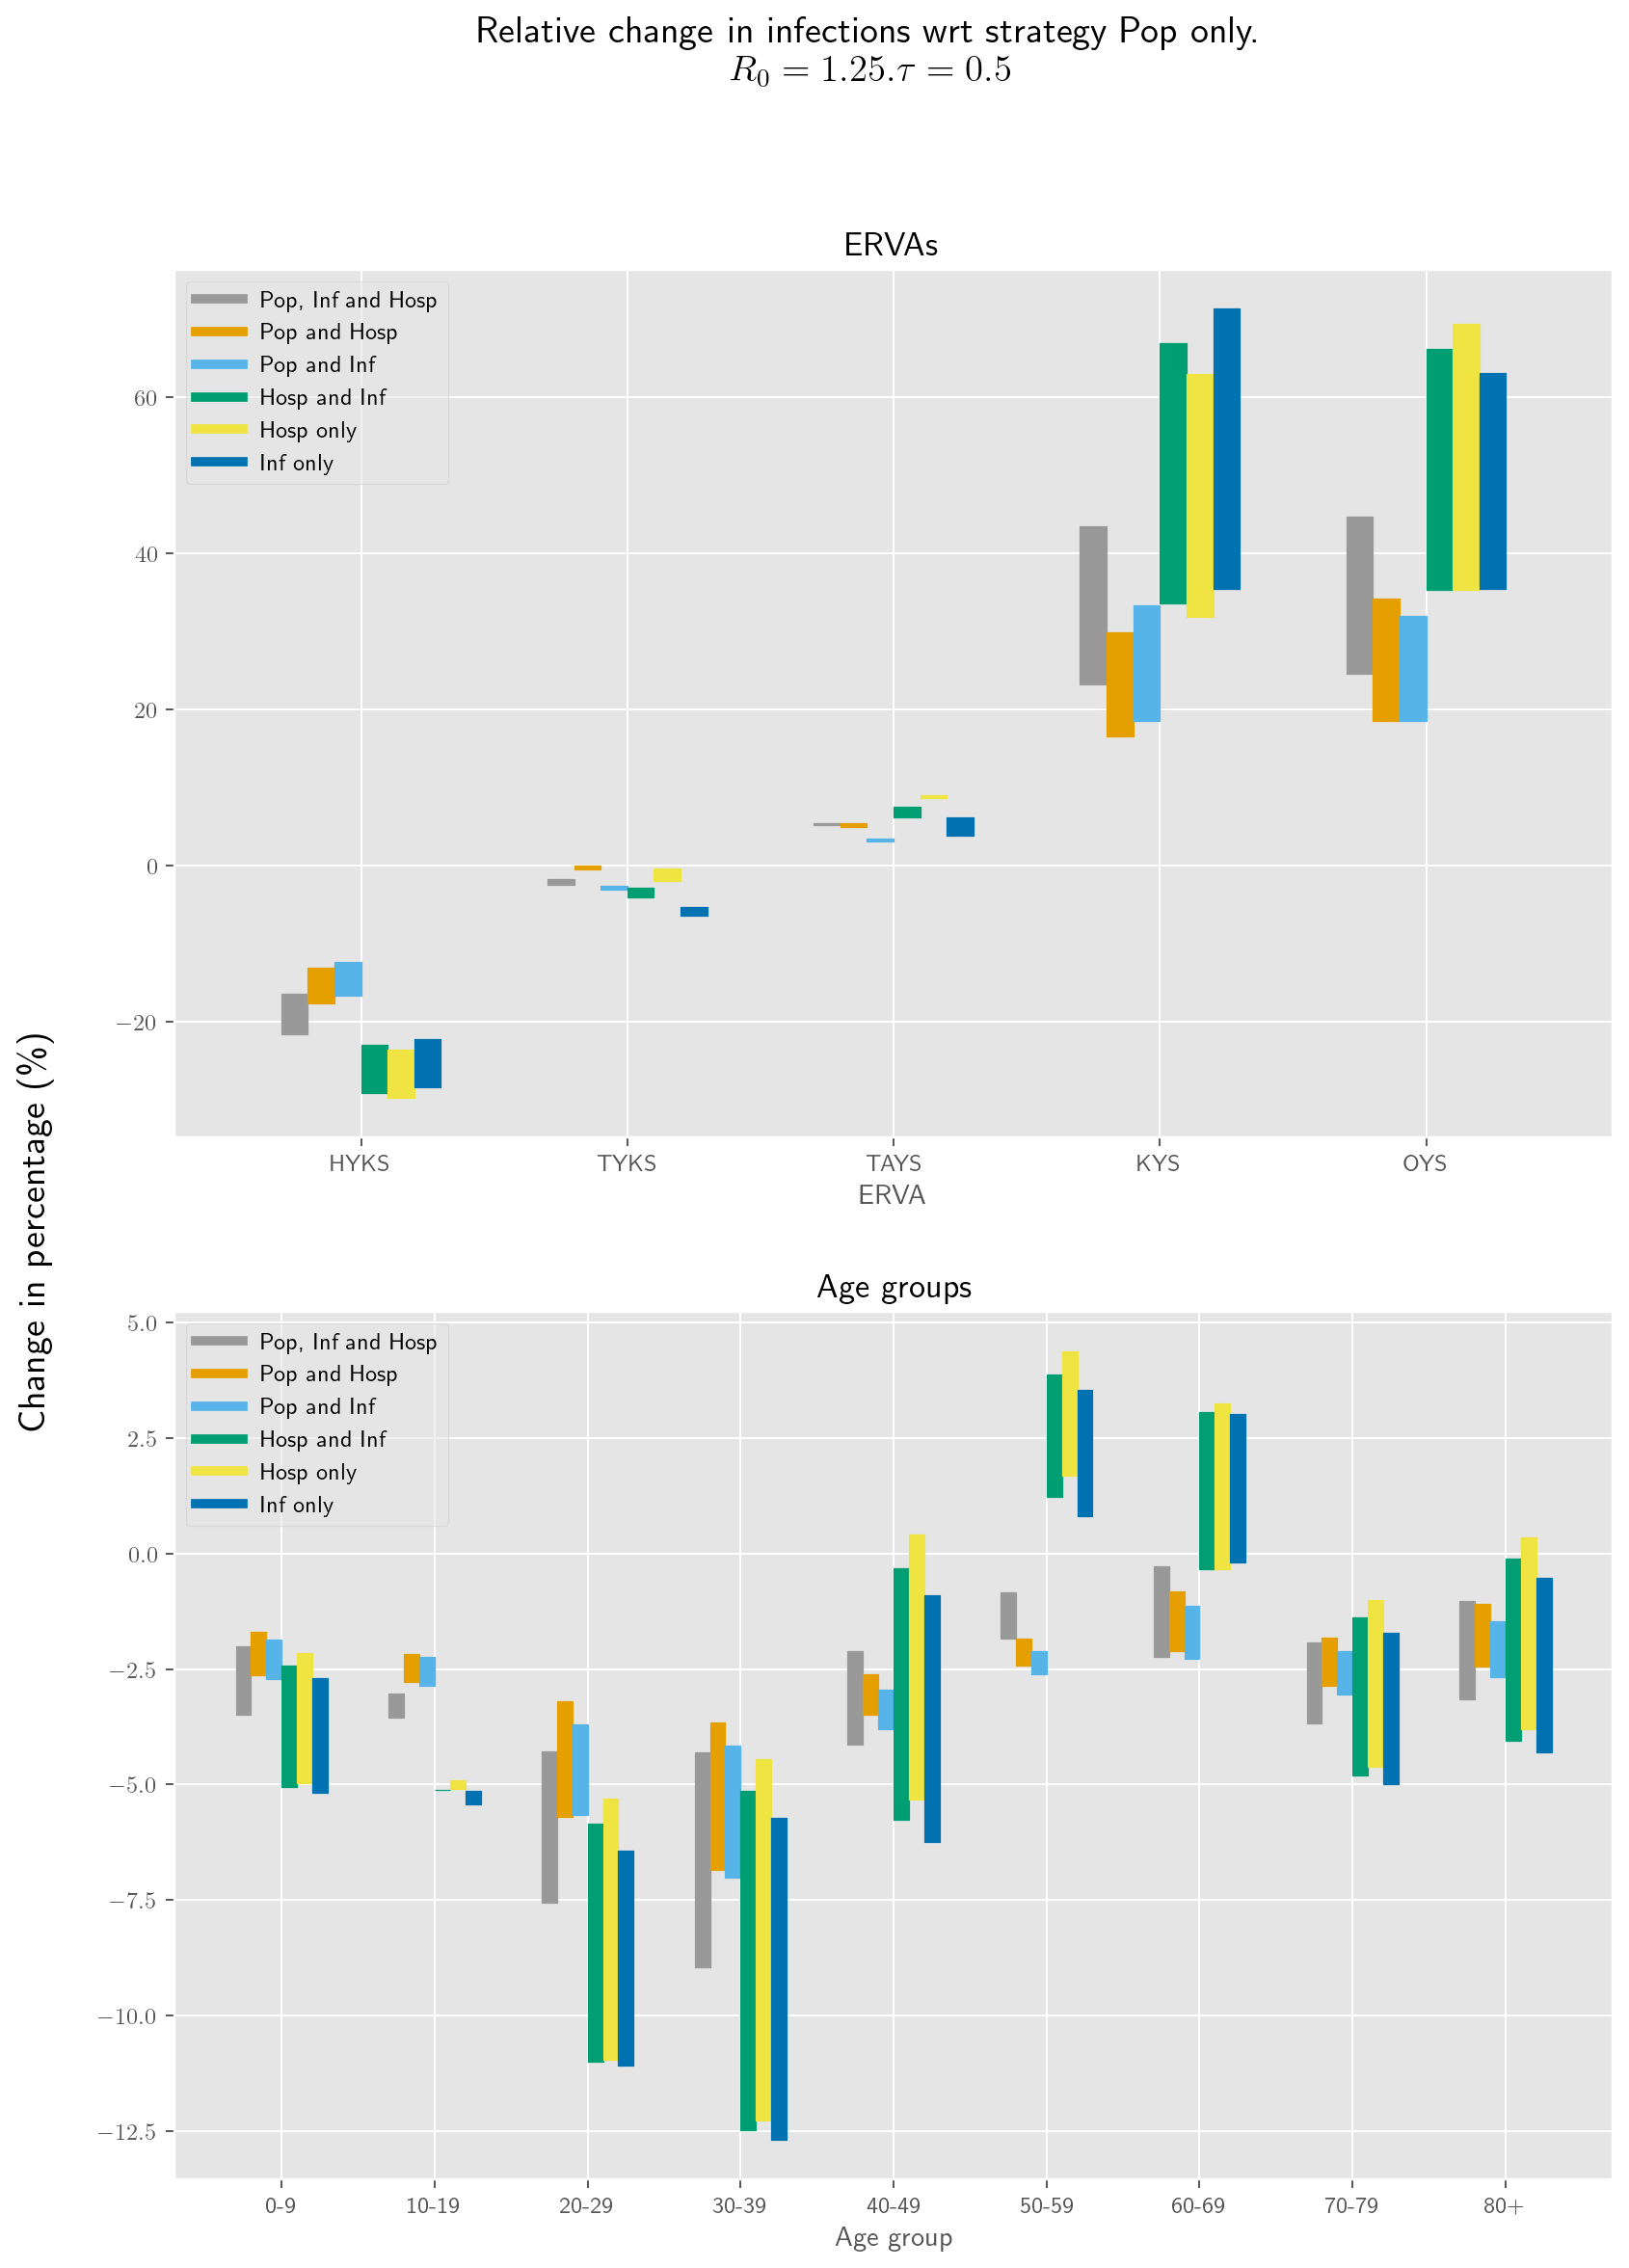

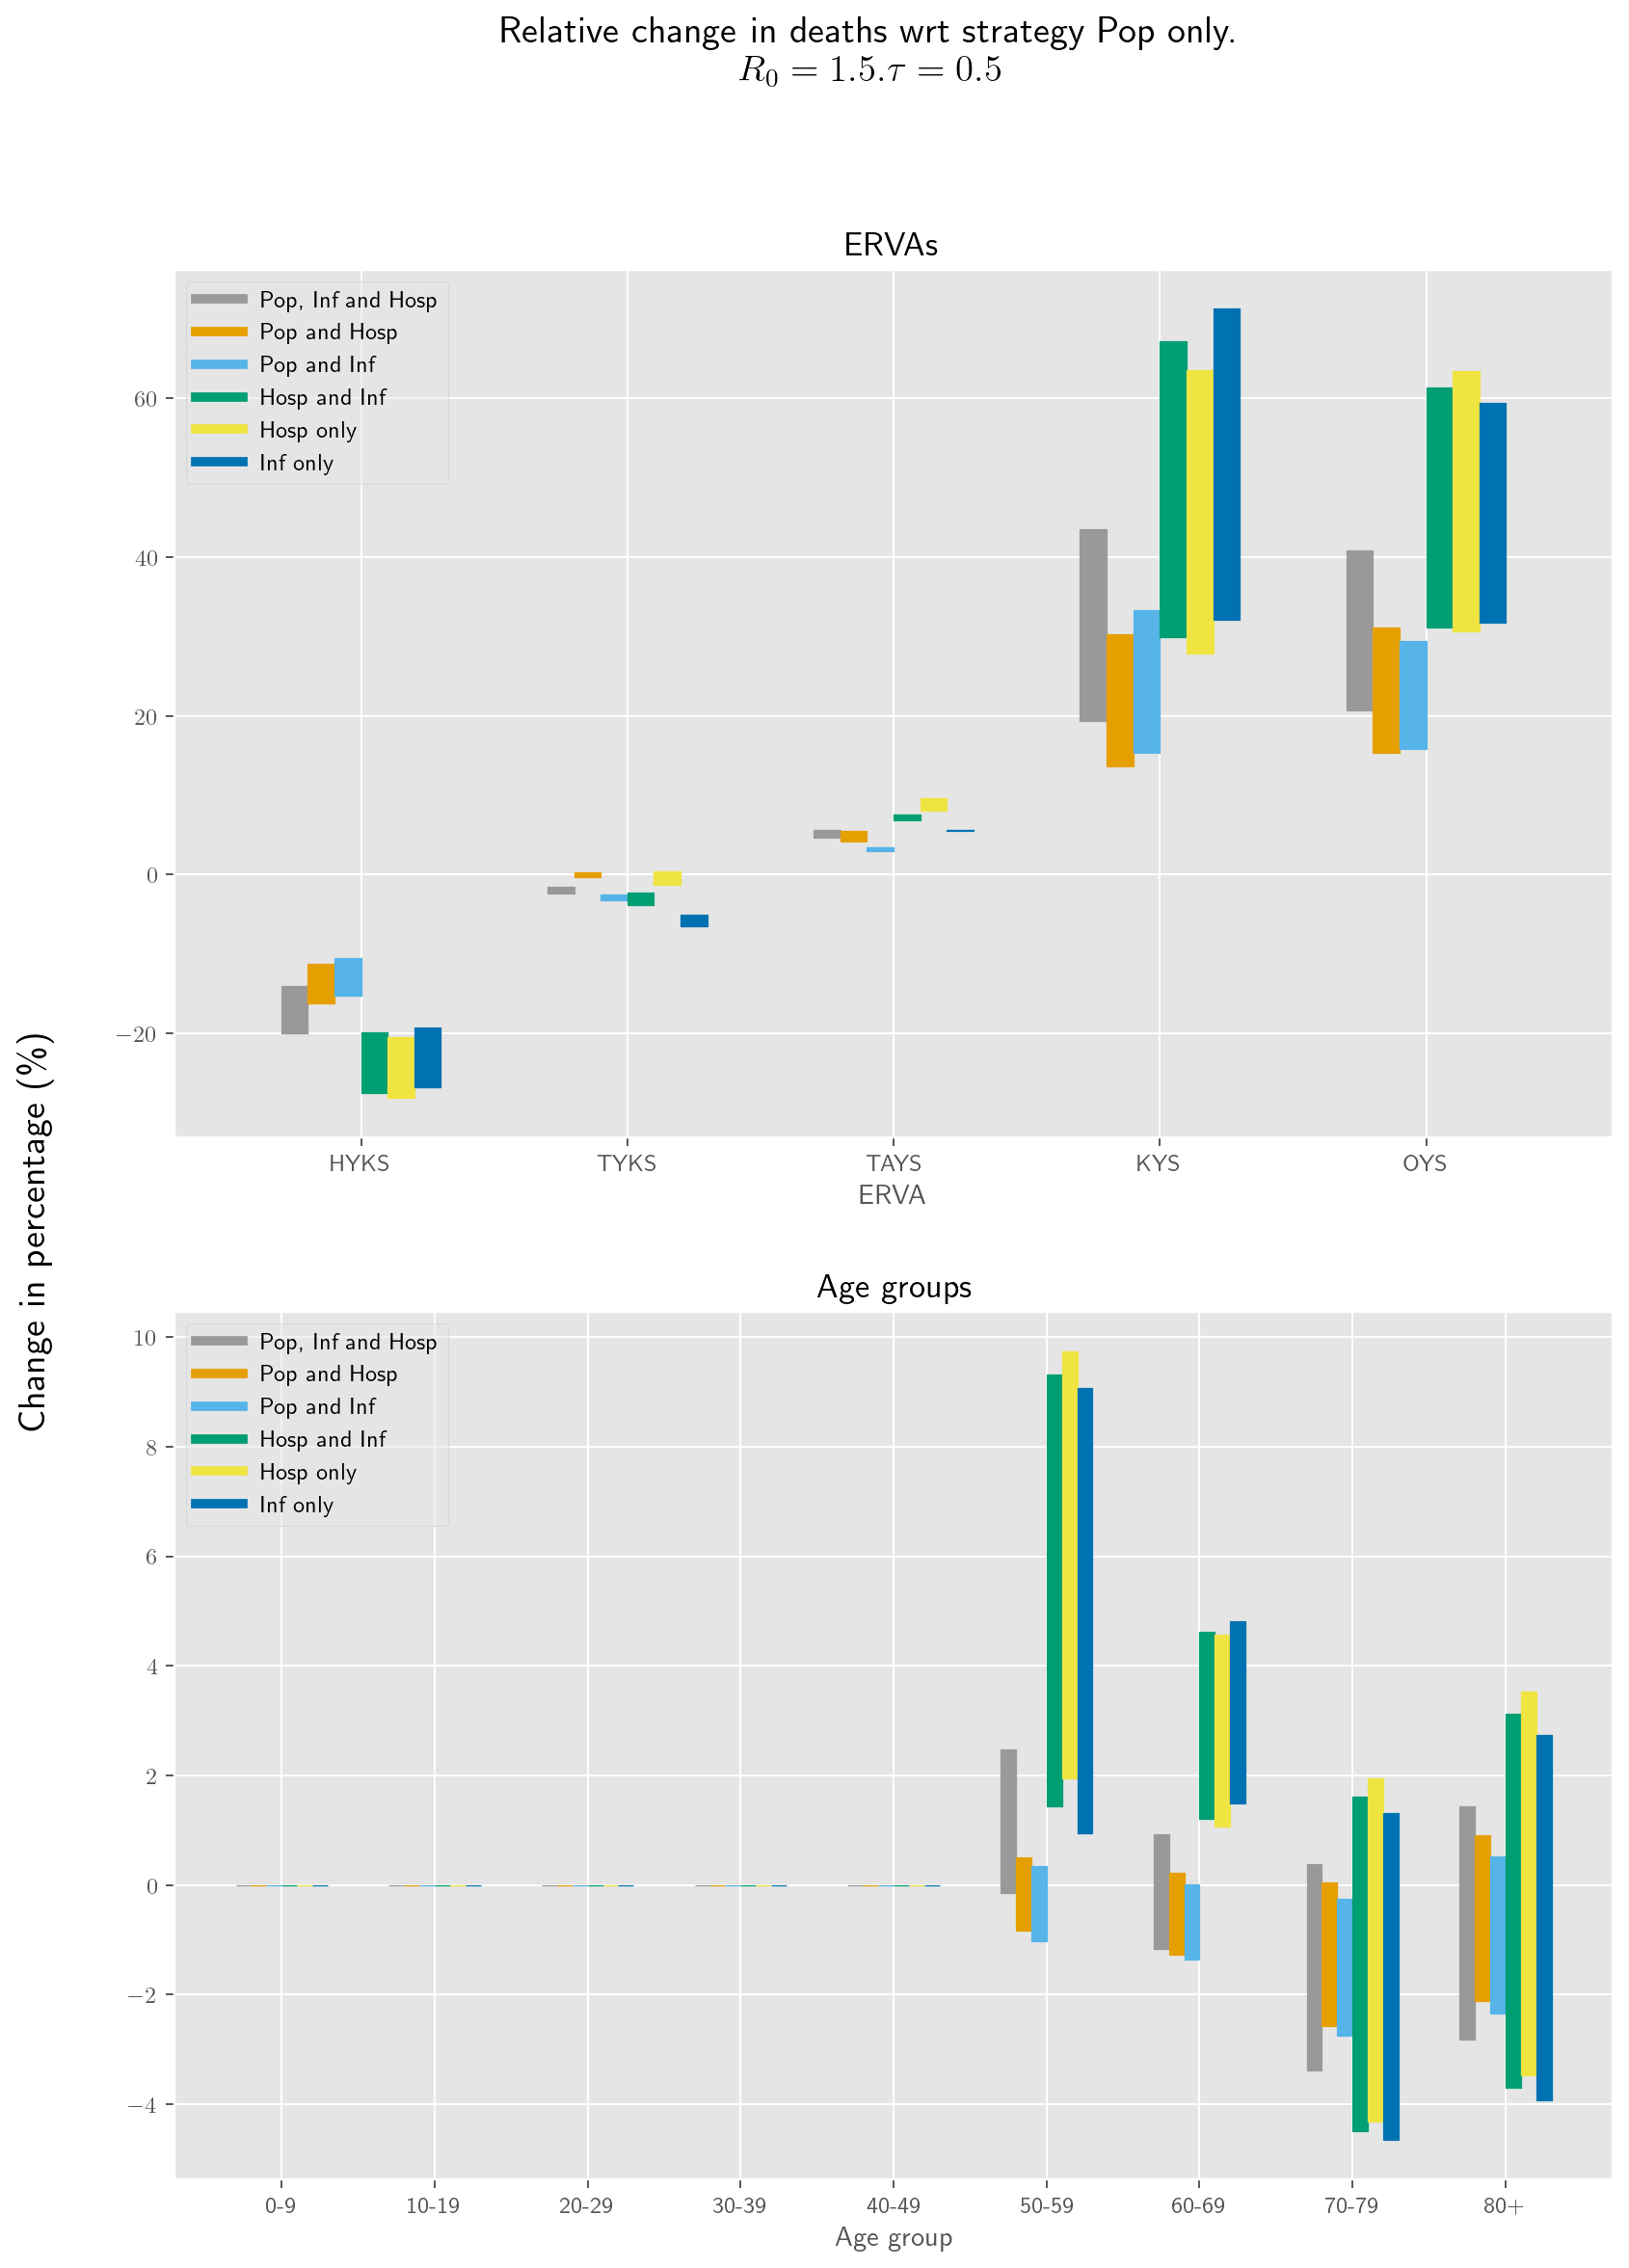

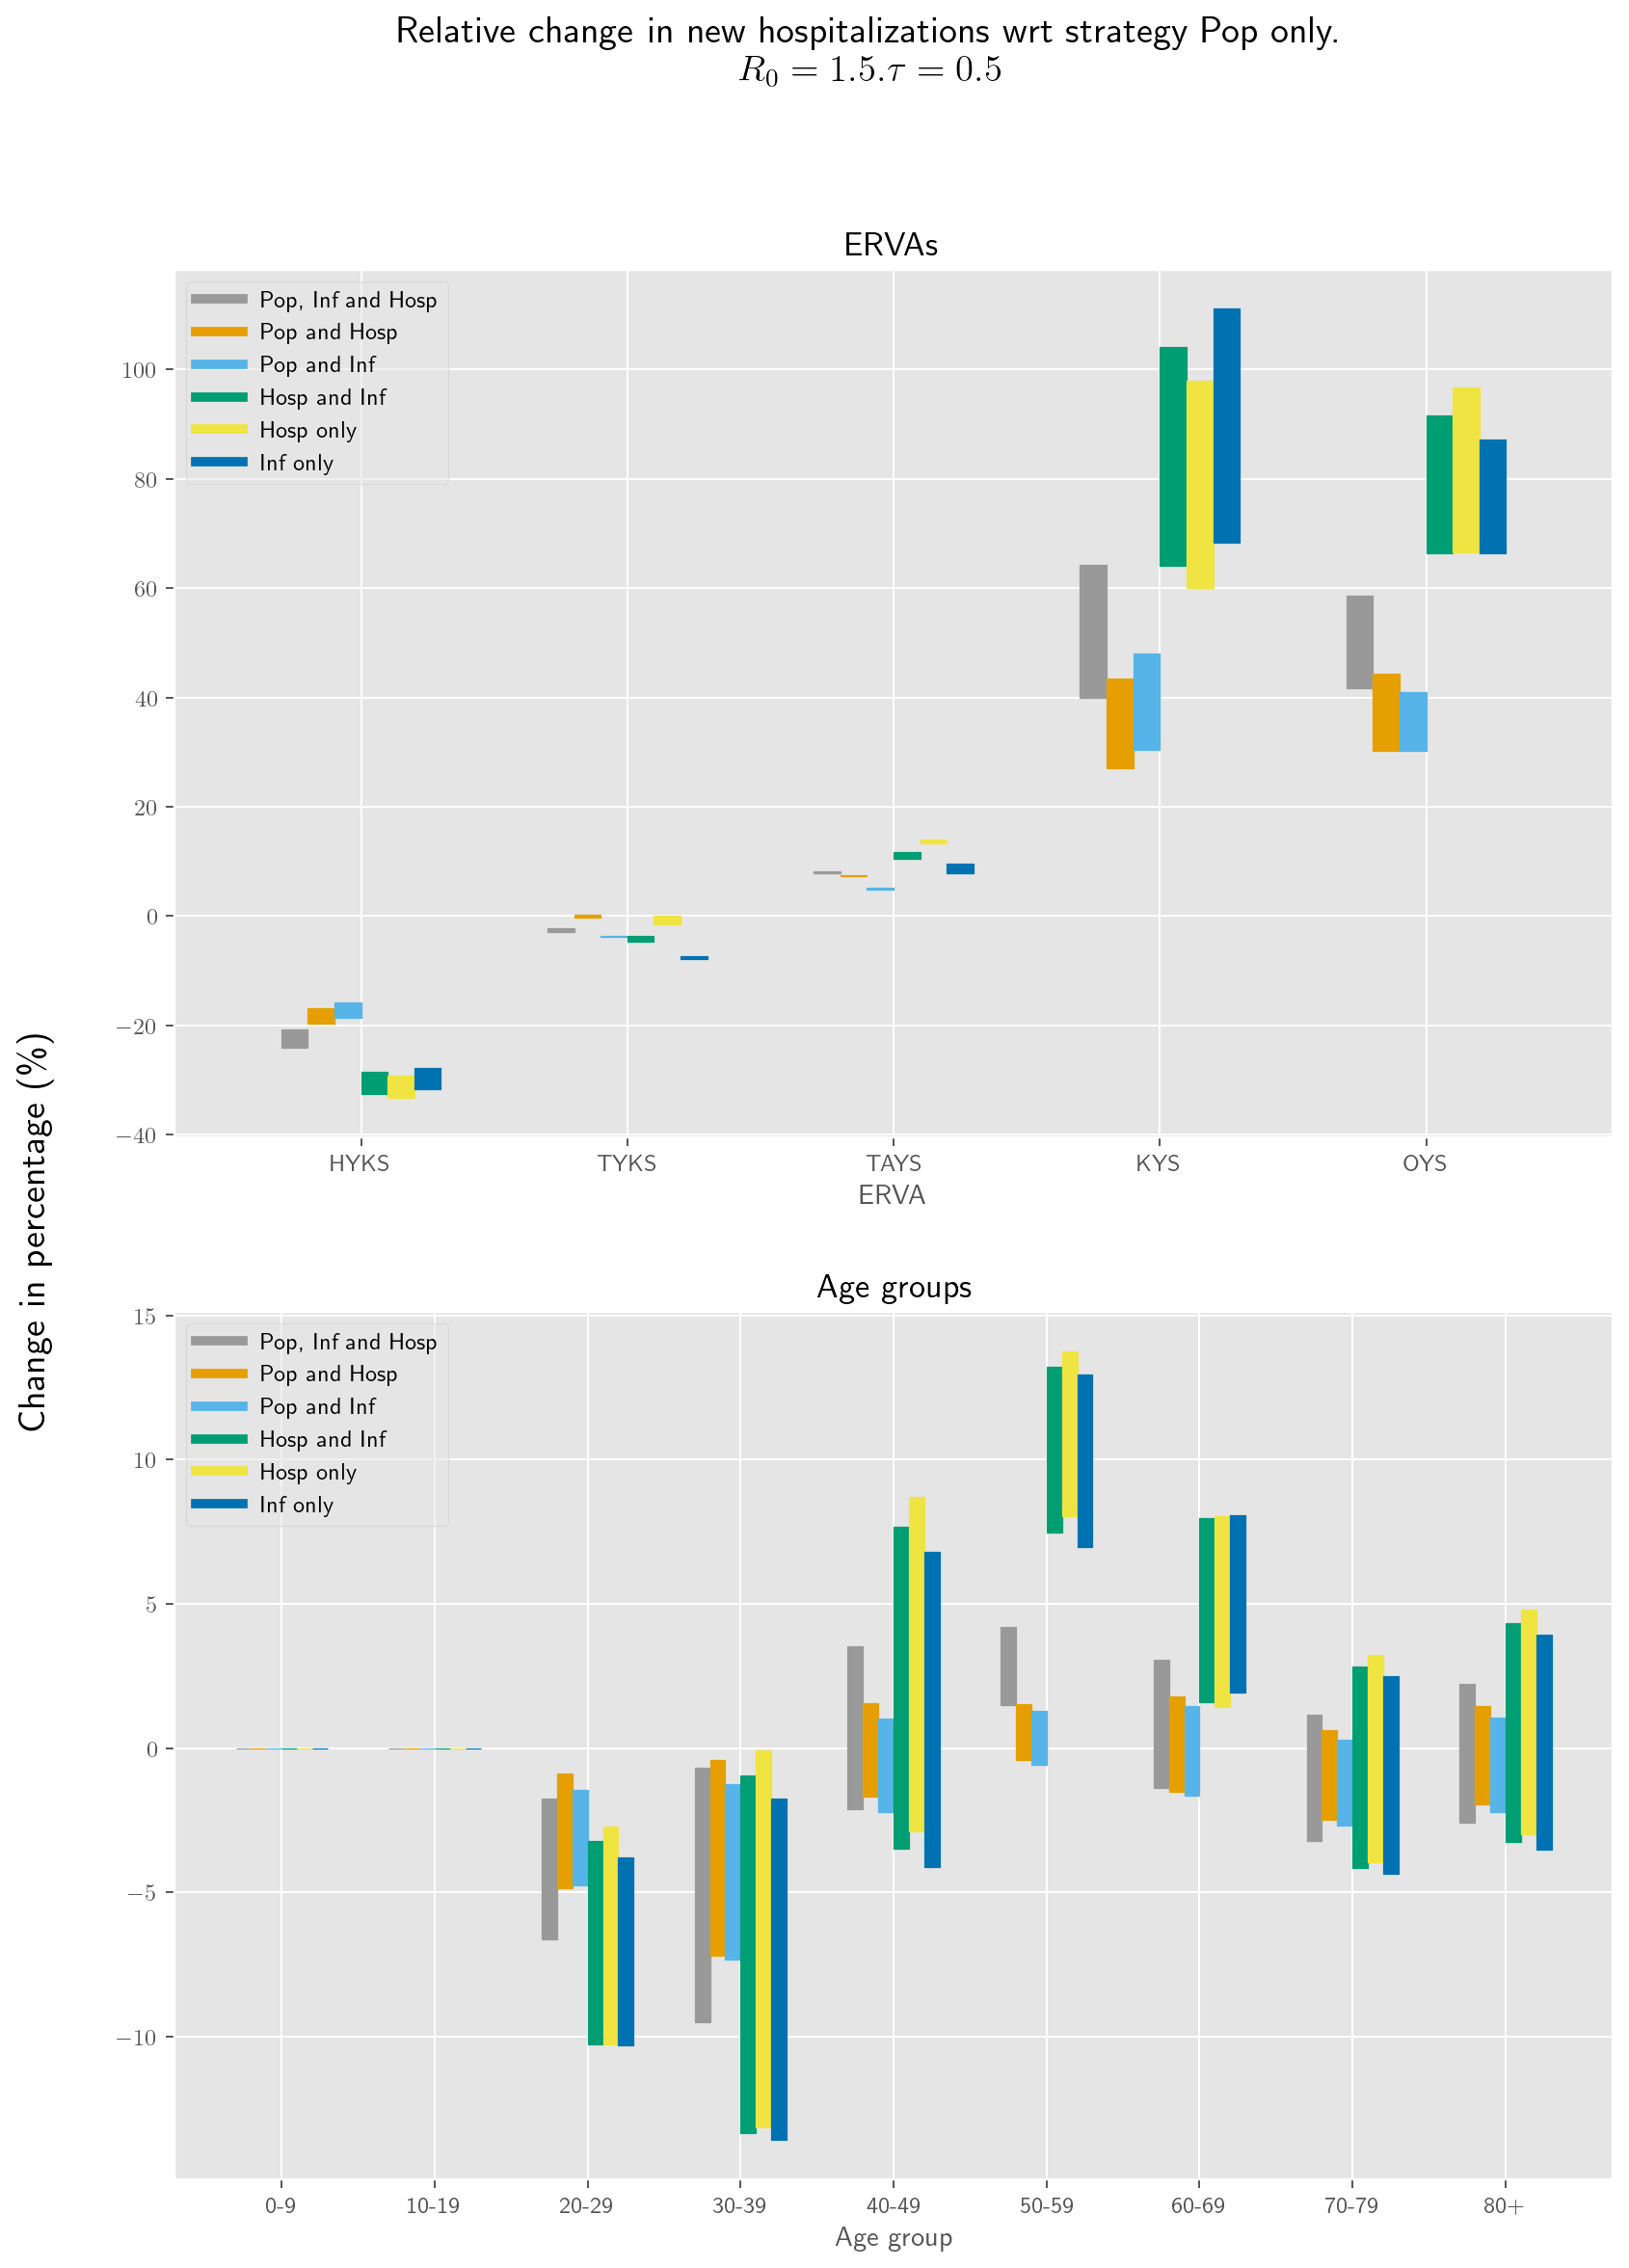

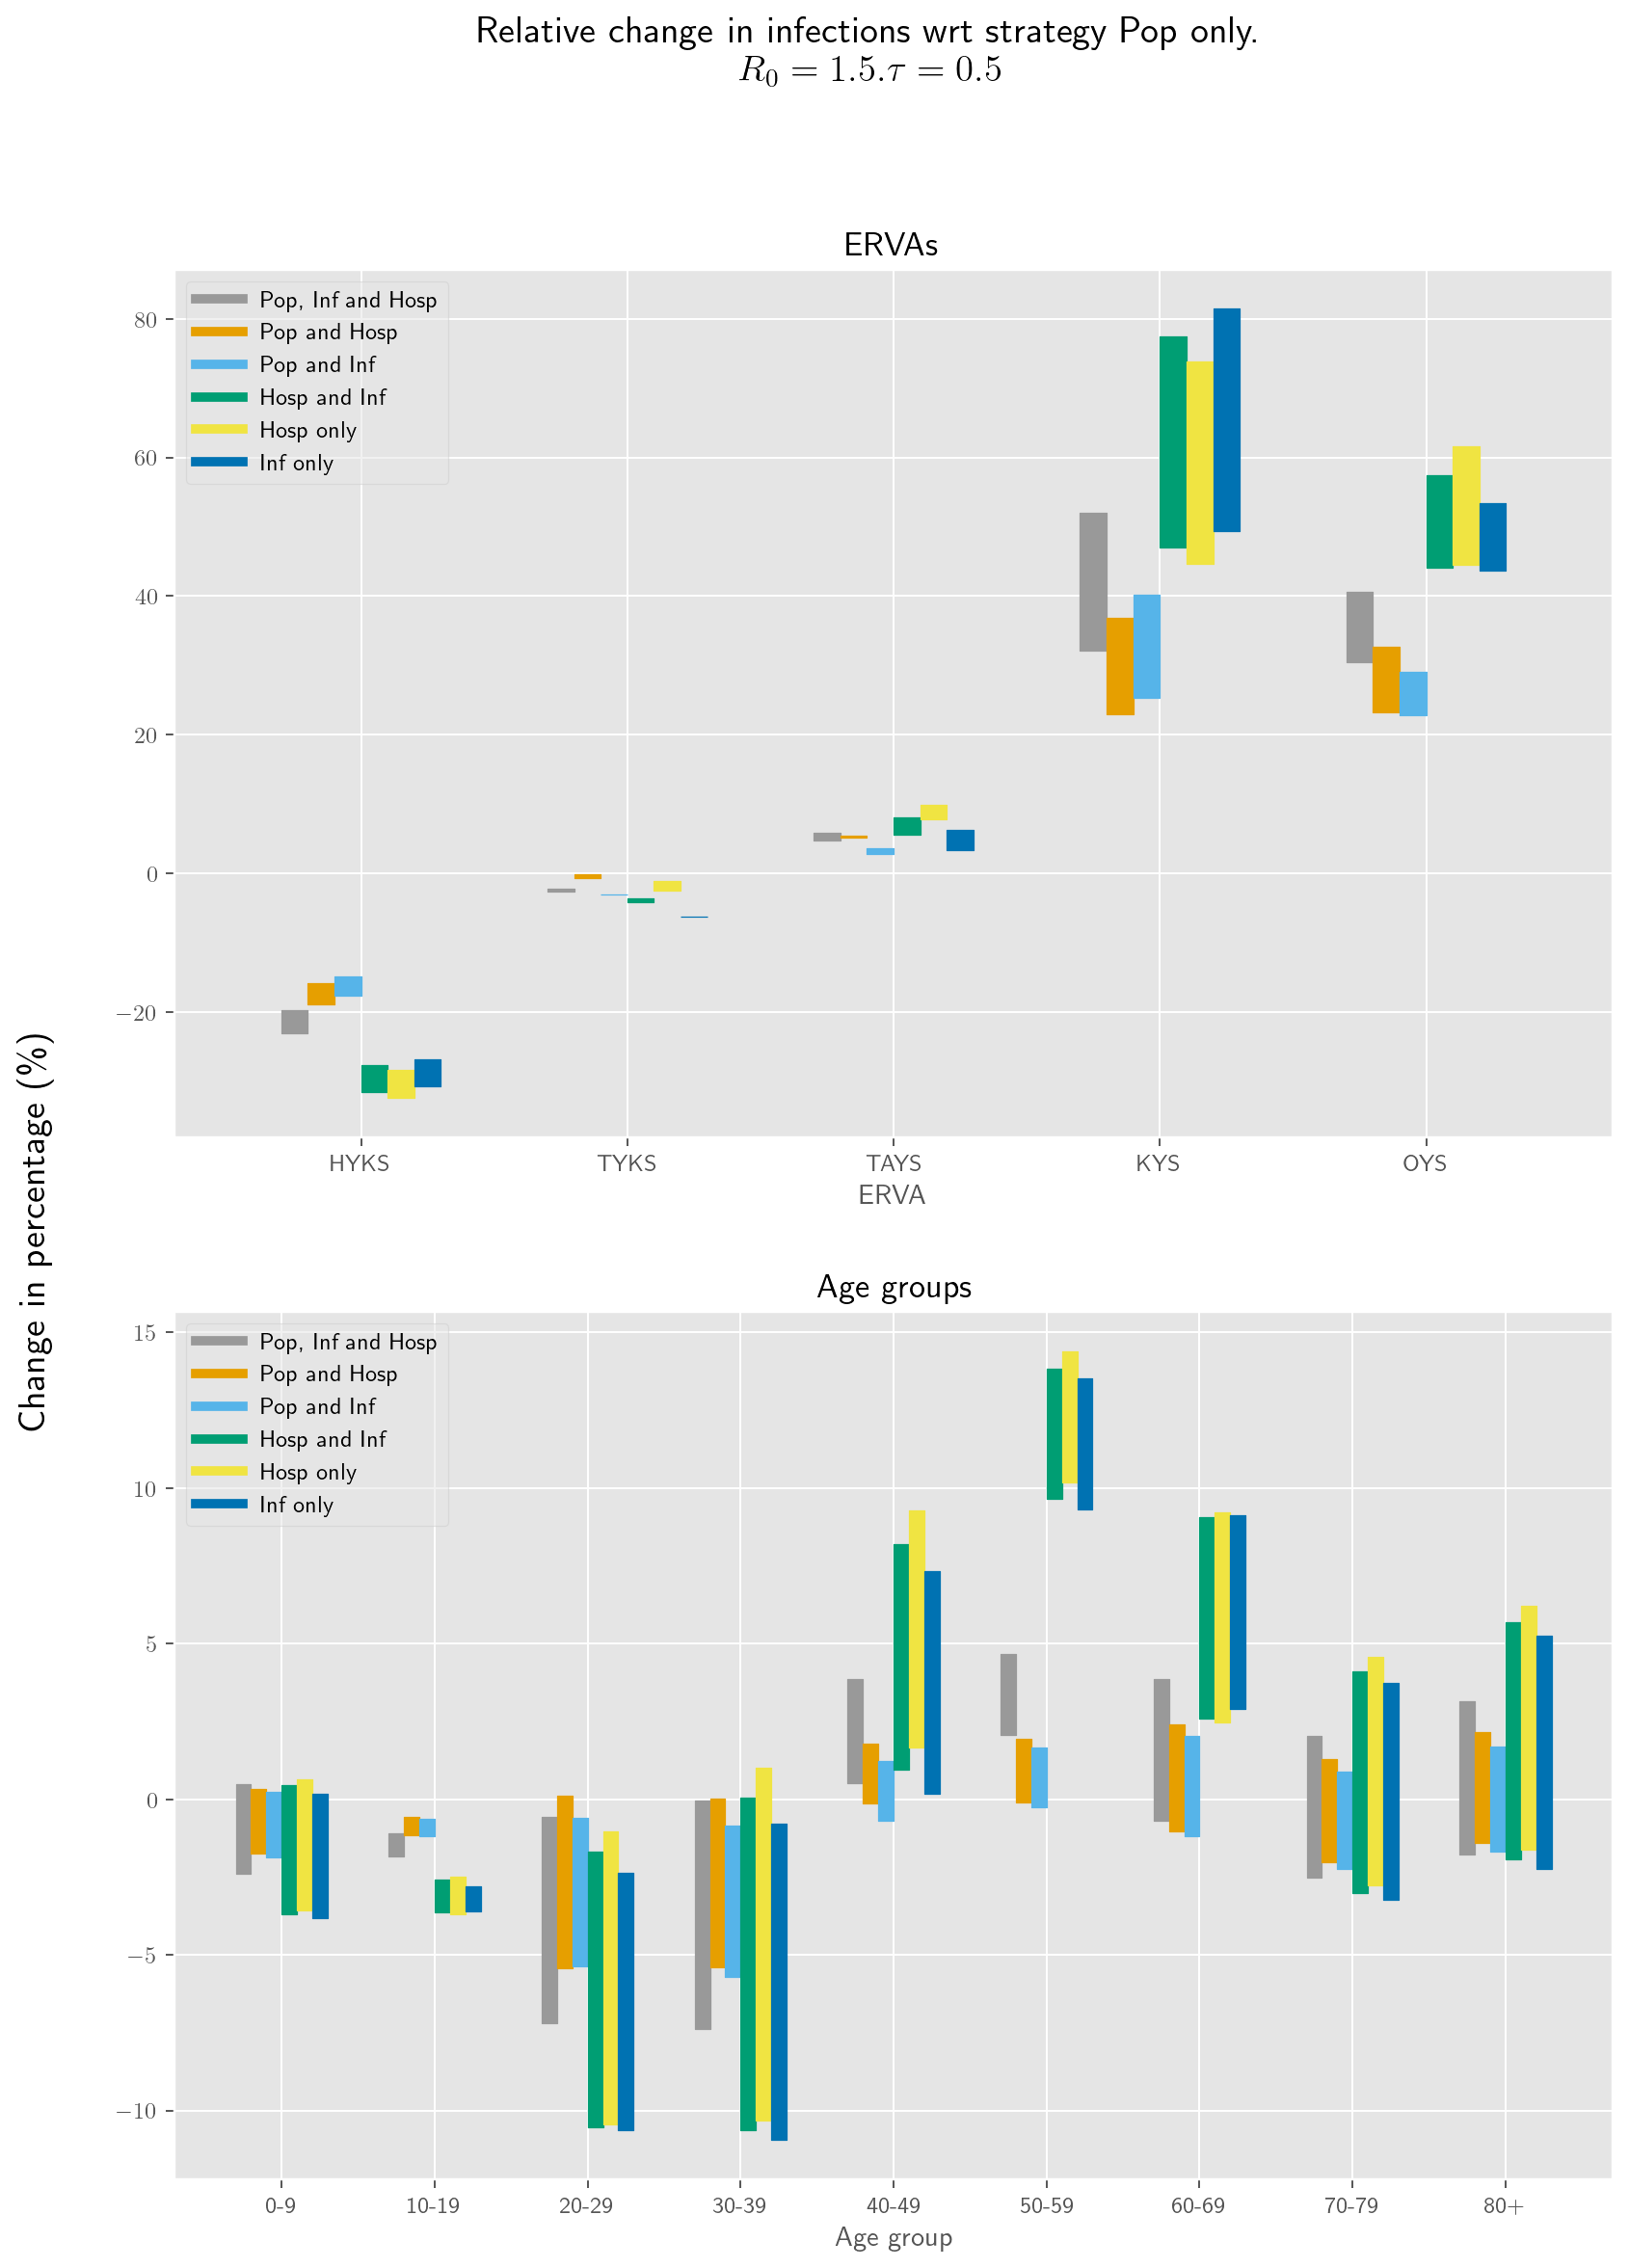

In [12]:
latex_template = """
    \\begin{{figure}}[p]
      \\centering
      \\includegraphics[width=\\textwidth]{{img/{fig_name}}}
      \\caption{{Relative change in {metric} for all vaccination strategies with respect to vaccination strategy {baseline}.
      The bars represent the relative change in cumulative {metric} between the end of the simulation and 30 days before the end of the simulation.
      For this scenario, the basic reproduction number $R_0 = {r}$ and the mobility value $\\tau = {tau}$.
      Top: Relative change at ERVA level, Bottom: Relative change at age group level.}}
      \\label{{fig:{name}}}
    \\end{{figure}}
"""
metrics = ['deaths', 'new hospitalizations', 'infections']
save_and_generate_latex(r_experiments=r_experiments, taus=[0.5], ervas_labels=ervas_labels, age_labels=age_labels,
                        metrics=metrics, exp_results=exp_results, skip_no_vacc=True,
                        img_dir=os.path.join('out', 'img'), t2=t2, t1=t1, baseline='Pop only',
                        file_format='pdf', latex_template=latex_template, dpis=2000)

In [13]:
def generate_results_table(r_experiments, taus, metric, baseline, exp_results, skip_no_vacc):
    table_dictionary = {}
    all_columns = set()
    # Iterate over all experiments
    for r in r_experiments:
        for tau in taus:
            # Group the results by r, tau
            key = (str(r), str(tau))
            table_dictionary[key] = {}
            results = exp_results[r][tau]
            # Iterate over all the strategies and get the counts
            for label, label_level in results.items():
                if label == baseline:
                    baseline_results = label_level['results'][metric]
                    baseline_results = baseline_results.sum()
                    table_dictionary[key]['baseline'] = {}
                    table_dictionary[key]['baseline']['count'] = baseline_results
                elif label == 'No vaccination' and skip_no_vacc:
                    continue
                else:
                    # Add to columns since this is not the baseline
                    all_columns.add(label)
                    strategy_results = label_level['results'][metric]
                    strategy_results = strategy_results.sum()
                    table_dictionary[key][label] = {}
                    table_dictionary[key][label]['count'] = strategy_results
                    table_dictionary[key][label]['best'] = False
    
    # Iterate over all r, tau combination
    for key, strategies_level in table_dictionary.items():
        best_strategy_val = np.inf
        last_best = None
        # Iterate over all the strategies
        for column in all_columns:
            # Get the difference to the baseline
            strategies_level[column]['diff_to_baseline'] = strategies_level[column]['count'] - strategies_level['baseline']['count']
            # Get the relative change wrt to the baseline
            strategies_level[column]['change_to_baseline'] = strategies_level[column]['count']/strategies_level['baseline']['count'] - 1
            strategies_level[column]['change_to_baseline'] = strategies_level[column]['change_to_baseline']*100
            
            # Check if this strategy is the best for the r, tau combination
            if strategies_level[column]['diff_to_baseline'] < best_strategy_val:
                best_strategy_val = strategies_level[column]['diff_to_baseline']
                strategies_level[column]['best'] = True
                if last_best is not None:
                    strategies_level[last_best]['best'] = False
                    
                last_best = column
    
    # Construct the latex tables
    header_latex = """
    \\begin{table}[h]
    \\centering
    \\tiny
    \\begin{tabular}{c|%s}
    \\toprule
    """
    header_latex = header_latex % ('c'*len(all_columns))
    header_titles = '\\bf $R_0, \\tau$ '
    for column in all_columns:
        header_titles += '& \\bf %s ' % column
    complete_header = header_latex + header_titles + '\\\\ \n \\midrule \n'
    
    # Iterate over the results and add them to the latex table
    lines_diff = ''
    lines_change = ''
    for key, strategies_level in table_dictionary.items():
        r_str, tau_str = key
        line_diff = '%s, %s ' % (r_str, tau_str)
        line_change = line_diff
        for column in all_columns:
            if strategies_level[column]['best']:
                line_diff += '& \\bf '
                line_change += '& \\bf '
            else:
                line_diff += '& '
                line_change += '& '
            line_diff += '%.2f ' % (round(strategies_level[column]['diff_to_baseline'], 2))
            line_change += '%.2f ' % (round(strategies_level[column]['change_to_baseline'], 2))
        line_diff += ' \\\\ \n'
        line_change += ' \\\\ \n'
        
        lines_diff += line_diff
        lines_change += line_change
    
    # Finish the tables with the captions
    tbl_diff = complete_header + lines_diff
    tbl_change = complete_header + lines_change
    
    end_table = """
    \\bottomrule
    \\end{tabular}
    """
    
    tbl_diff += end_table
    tbl_change += end_table
    
    tbl_diff += """
    \\caption{\\label{tab:ResultsRTauDiff} Difference in %s of each vaccination strategy compared to strategy Pop only.
    Each row $p$ contains the results for a pair of parameters $R_0$ and $\\tau$ while each column $s$ for a vaccination strategy.
    The value in cell $p,s$ is the difference in %s between strategy $s$ and Pop only at scenario with parameters $p$.
    The lowest difference at row $p$ is indicated in bold face.}
    \\end{table}
    """
    tbl_diff = tbl_diff % (metric, metric)
    
    tbl_change += """
    \\caption{\\label{tab:ResultsRTauDiff} Relative change in %s with each vaccination strategy compared to strategy Pop only.
    Each row $p$ contains the results for a pair of parameters $R_0$ and $\\tau$ while each column $s$ for a vaccination strategy.
    The value in cell $p,s$ is the relative change in %s with strategy $s$ wrt. Pop only at scenario with parameters $p$.
    The lowest relative change at row $p$ is indicated in bold face.}
    \\end{table}
    """
    tbl_change = tbl_change % (metric, metric)

    return tbl_diff, tbl_change

In [14]:
metrics = ['deaths', 'new hospitalizations', 'infections']
for metric in metrics:
    tbl_diff, tbl_change = generate_results_table(r_experiments, taus, metric=metric, baseline='Pop only',
                                                  exp_results=exp_results, skip_no_vacc=True)
    print(tbl_diff)
    print(tbl_change)


    \begin{table}[h]
    \centering
    \tiny
    \begin{tabular}{c|cccccc}
    \toprule
    \bf $R_0, \tau$ & \bf Hosp and Inf & \bf Hosp only & \bf Pop, Inf and Hosp & \bf Pop and Inf & \bf Inf only & \bf Pop and Hosp \\ 
 \midrule 
0.75, 0 & -0.26 & -0.24 & -0.20 & -0.17 & \bf -0.28 & -0.15  \\ 
0.75, 0.5 & -0.40 & -0.38 & -0.31 & -0.25 & \bf -0.42 & -0.23  \\ 
0.75, 1.0 & -0.57 & -0.55 & -0.42 & -0.34 & \bf -0.58 & -0.32  \\ 
1.0, 0 & -1.74 & -1.59 & -1.42 & -1.24 & \bf -1.87 & -1.10  \\ 
1.0, 0.5 & -3.25 & -3.07 & -2.57 & -2.18 & \bf -3.40 & -2.02  \\ 
1.0, 1.0 & -5.77 & -5.61 & -4.34 & -3.54 & \bf -5.90 & -3.39  \\ 
1.25, 0 & -3.18 & -1.76 & -4.60 & \bf -5.24 & -4.48 & -4.04  \\ 
1.25, 0.5 & -11.21 & -9.63 & -11.48 & -11.24 & \bf -12.65 & -9.86  \\ 
1.25, 1.0 & -35.06 & -33.93 & -28.12 & -23.84 & \bf -36.09 & -22.84  \\ 
1.5, 0 & 53.49 & 61.95 & 23.82 & \bf 7.81 & 45.82 & 15.29  \\ 
1.5, 0.5 & 51.09 & 58.44 & 19.45 & \bf 3.38 & 44.53 & 10.21  \\ 
1.5, 1.0 & -31.00 & -26.50 & -35